In [6]:
import os
import cv2
import torch
import numpy as np
from PIL import Image
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import shutil
import yaml
import torch
from ultralytics import YOLO
from tqdm import tqdm
import os
import shutil
import yaml
import torch
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from tqdm import tqdm
from motmetrics import MOTAccumulator, metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import os
import torch
import cv2
import numpy as np
from deep_sort_realtime.deepsort_tracker import DeepSort
from ultralytics import YOLO
import motmetrics as mm
import re
from tqdm import tqdm
import cv2
import numpy as np
from collections import defaultdict
import supervision as sv
import cv2

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
# !pip install deep_sort_realtime

part 1

for sportsmot

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define paths
dataset_root = "../input/sportsmot/sportsmot_publish/dataset"
splits_root = "../input/sportsmot/sportsmot_publish/splits_txt"

# Load football sequences
def load_split(file_name):
    file_path = os.path.join(splits_root, file_name)
    if os.path.exists(file_path):
        with open(file_path, "r") as f:
            return [line.strip() for line in f.readlines()]
    return []

# Load football video names
football_files = set(load_split("football.txt"))

# Filter splits for football only
train_files = [x for x in load_split("train.txt") if x in football_files]
val_files = [x for x in load_split("val.txt") if x in football_files]
test_files = [x for x in load_split("test.txt") if x in football_files]


In [12]:
def get_transform(train):
    transform_list = [
        transforms.ToPILImage(),
        transforms.Resize((224, 224))
    ]
    if train:
        transform_list.extend([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        ])
    transform_list.extend([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transforms.Compose(transform_list)

def load_annotations(annotation_path):
    boxes = []
    labels = []
    if os.path.exists(annotation_path):
        with open(annotation_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                if len(parts) < 8:
                    continue
                x, y, w, h = map(float, parts[2:6])
                cls_id = int(parts[7])
                
                # Convert to x1,y1,x2,y2
                boxes.append([x, y, x + w, y + h])
                labels.append(cls_id + 1)  # Assuming class starts at 0, add 1 for background class 0
    
    if boxes:
        return torch.tensor(boxes, dtype=torch.float32), torch.tensor(labels, dtype=torch.int64)
    return torch.empty((0, 4), dtype=torch.float32), torch.empty(0, dtype=torch.int64)

class FootballDataset(Dataset):
    def __init__(self, video_folders, root_dir,locate, is_train=True):
        self.root_dir = root_dir
        self.transform = get_transform(is_train)
        self.samples = []
        
        for video in video_folders:
            img_dir = os.path.join(root_dir,locate, video, 'img1')
            gt_dir = os.path.join(root_dir,locate, video, 'gt')
            
            for img_path in sorted(glob.glob(os.path.join(img_dir, '*.jpg'))):
                frame_num = int(os.path.splitext(os.path.basename(img_path))[0])
                ann_path = os.path.join(gt_dir, f"{frame_num:06d}.txt")
                self.samples.append((img_path, ann_path))
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, ann_path = self.samples[idx]
       # Load image
        img = cv2.imread(img_path)
        if img is None:
            return None, None
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        img = self.transform(img)
        
        # Load annotations
        boxes, labels = load_annotations(ann_path)
        
        return img, {'boxes': boxes, 'labels': labels}

# Create datasets and dataloaders
train_dataset = FootballDataset(train_files, dataset_root,"train", is_train=True)
val_dataset = FootballDataset(val_files, dataset_root,"val", is_train=False)
test_dataset = FootballDataset(test_files, dataset_root,"test", is_train=False)


In [13]:
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    if len(batch) == 0:
        return None, None
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, targets

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

1.2.1 

YOLO (You Only Look Once) is a fast object detection model that works well for real-time applications like surveillance or robotics. Its speed comes from processing the entire image at once, but this can sometimes sacrifice accuracy, especially for small or overlapping objects. It's a great choice if you need speed over precision.

On the other hand, **Faster R-CNN** offers higher accuracy, especially for detecting smaller or more complex objects, thanks to its use of Region Proposal Networks (RPN). While it's slower and more computationally demanding than YOLO, it's ideal for tasks that require precise object localization and detailed detection, like medical imaging or complex scenes.

I need real-time results, **YOLO** is the better choice for me and i try to turn it more to have the accuracy as well.

1.2.2

In [87]:
# Ensure everything runs on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset_root = "/kaggle/input/sportsmot/sportsmot_publish/dataset"
splits_root = "/kaggle/input/sportsmot/sportsmot_publish/splits_txt"
output_root = "/kaggle/working/yolo_dataset"

football_sequences = set()
football_file = os.path.join(splits_root, "football.txt")

with open(football_file, "r") as f:
    football_sequences = set(line.strip() for line in f)

for split in ["train", "val"]:
    os.makedirs(os.path.join(output_root, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(output_root, split, "labels"), exist_ok=True)


In [88]:
def convert_mot_to_yolo(sequence_path, split):
    
    seqinfo_path = os.path.join(sequence_path, "seqinfo.ini")
    with open(seqinfo_path, "r") as f:
        seqinfo = {line.split('=')[0]: line.split('=')[1].strip() for line in f if '=' in line}
    img_width = int(seqinfo["imWidth"])
    img_height = int(seqinfo["imHeight"])
    
    gt_path = os.path.join(sequence_path, "gt/gt.txt")
    with open(gt_path, "r") as f:
        annotations = [line.strip().split(",") for line in f]
    
    frame_annotations = {}
    for ann in annotations:
        frame_id, _, x, y, w, h, _, class_id, _ = map(float, ann[:9])
        frame_id = int(frame_id)
        
        # Normalize
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        norm_width = w / img_width
        norm_height = h / img_height
        
        if frame_id not in frame_annotations:
            frame_annotations[frame_id] = []
        frame_annotations[frame_id].append(f"{int(class_id-1)} {x_center:.6f} {y_center:.6f} {norm_width:.6f} {norm_height:.6f}")
    
    for frame_id, ann_list in frame_annotations.items():
        img_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.jpg"  # Add sequence name to make filename unique
        label_name = f"{sequence_path.split('/')[-1]}_{frame_id:06d}.txt"
        
        img_src = os.path.join(sequence_path, "img1", f"{frame_id:06d}.jpg")
        img_dst = os.path.join(output_root, split, "images", img_name)
        if os.path.exists(img_src):
            shutil.copy(img_src, img_dst)
        
        label_dst = os.path.join(output_root, split, "labels", label_name)
        with open(label_dst, "w") as f:
            f.write("\n".join(ann_list))

for split in ["train", "val"]:
    split_file = os.path.join(splits_root, f"{split}.txt")
    
    with open(split_file, "r") as f:
        sequences = [line.strip() for line in f]
    
    for seq in tqdm(sequences, desc=f"Processing {split} split"):
        if seq in football_sequences:  # Only process football sequences
            sequence_path = os.path.join(dataset_root, split, seq)
            if os.path.exists(sequence_path):
                convert_mot_to_yolo(sequence_path, split)

print("Conversion complete. YOLO dataset is in:", output_root)


Processing val split: 100%|██████████| 45/45 [00:14<00:00,  3.16it/s]

Conversion complete. YOLO dataset is in: /kaggle/working/yolo_dataset


In [68]:

# # Ensure the directory exists
# os.makedirs(output_root, exist_ok=True)

# Create YAML content
yaml_content = {
    'path': output_root,
    'train': 'train/images',
    'val': 'val/images',
    'nc': 1,
    'names': ["player"]
}

# Define YAML path
yaml_path = os.path.join(output_root, "sportsmot.yaml")

# Write YAML file
with open(yaml_path, "w") as f:
    yaml.dump(yaml_content, f)

print(f"YAML file created at: {yaml_path}")

# Train YOLO model on GPU
device = "cuda"  # Change to "cpu" if no GPU is available
model = YOLO("yolov8n.pt").to(device)
model = YOLO("/kaggle/input/combined2/pytorch/default/1/Best34.pt")

YAML file created at: /kaggle/working/yolo_dataset/sportsmot.yaml


100%|██████████| 6.25M/6.25M [00:00<00:00, 86.6MB/s]


In [69]:
results = model.train(data=yaml_path, epochs=50, imgsz=640, device=device, verbose=True)
print("Training complete.")


Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/combined2/pytorch/default/1/Best34.pt, data=/kaggle/working/yolo_dataset/sportsmot.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, sav

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.8MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/yolo_dataset/train/labels.cache... 11113 images, 0 backgrounds, 0 corrupt: 100%|██████████| 11113/11113 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/yolo_dataset/val/labels.cache... 9058 images, 0 backgrounds, 0 corrupt: 100%|██████████| 9058/9058 [00:00<?, ?it/s]

val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000456.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000462.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000475.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000482.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000485.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000492.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000494.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000499.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /kaggle/working/yolo_dataset/val/images/v_i2_L4qquVg0_c006_000500.jpg: 1

Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.97G     0.8553     0.5708     0.8399        192        640: 100%|██████████| 695/695 [02:05<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.919      0.959      0.933      0.749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.2G     0.7636       0.39     0.8235        180        640: 100%|██████████| 695/695 [01:59<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.925      0.939      0.945      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.41G     0.7425     0.3789     0.8208        187        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:46<00:00,  6.04it/s]


                   all       9058     117024      0.917      0.944      0.949      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       2.9G     0.7372     0.3715     0.8196        185        640: 100%|██████████| 695/695 [01:58<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024       0.92      0.951      0.934      0.765

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       3.3G     0.7178     0.3626     0.8171        182        640: 100%|██████████| 695/695 [01:57<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.921      0.951       0.93      0.759

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.97G     0.7064     0.3548     0.8153        239        640: 100%|██████████| 695/695 [01:57<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.91it/s]


                   all       9058     117024      0.917      0.942      0.928      0.757

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.36G     0.6988      0.351     0.8142        178        640: 100%|██████████| 695/695 [01:57<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.91it/s]


                   all       9058     117024      0.923      0.947      0.928       0.76

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.12G     0.6916     0.3468     0.8138        154        640: 100%|██████████| 695/695 [01:58<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024      0.924      0.946      0.943      0.777

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.03G     0.6858     0.3419     0.8135        235        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024      0.925      0.947      0.947      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.16G      0.676     0.3393     0.8121        204        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.87it/s]


                   all       9058     117024      0.919      0.943      0.943      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.38G     0.6726     0.3359     0.8113        179        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.87it/s]


                   all       9058     117024      0.925      0.937      0.942      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.89G      0.664     0.3314     0.8098        177        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.89it/s]


                   all       9058     117024      0.925      0.946      0.938       0.77

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.76G     0.6646     0.3316     0.8102        181        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024       0.92      0.937      0.933      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.84G     0.6605     0.3285     0.8095        236        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.925      0.937      0.934      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.39G     0.6497     0.3244     0.8087        142        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024      0.919      0.935       0.93      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.97G     0.6485     0.3231     0.8082        225        640: 100%|██████████| 695/695 [01:57<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.85it/s]


                   all       9058     117024       0.92      0.946      0.933      0.766

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.07G     0.6462      0.321     0.8073        168        640: 100%|██████████| 695/695 [01:58<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.90it/s]


                   all       9058     117024      0.926      0.924      0.945      0.782

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.19G     0.6404      0.318     0.8065        253        640: 100%|██████████| 695/695 [01:58<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.88it/s]

                   all       9058     117024      0.923      0.936      0.928      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.29G     0.6371     0.3153     0.8058        221        640: 100%|██████████| 695/695 [01:57<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]

                   all       9058     117024      0.925      0.938      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.06G     0.6299     0.3119     0.8059        186        640: 100%|██████████| 695/695 [01:58<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024      0.924       0.94       0.93      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.22G     0.6299     0.3129     0.8059        178        640: 100%|██████████| 695/695 [01:57<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]


                   all       9058     117024      0.923      0.944       0.93      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.21G     0.6307     0.3114     0.8055        198        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.93it/s]


                   all       9058     117024      0.924      0.942      0.941      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.38G     0.6242     0.3087      0.804        152        640: 100%|██████████| 695/695 [01:58<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.82it/s]


                   all       9058     117024      0.924      0.941      0.935      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.81G     0.6221     0.3069      0.804        244        640: 100%|██████████| 695/695 [01:59<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:49<00:00,  5.72it/s]


                   all       9058     117024      0.924       0.94      0.933      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.66G     0.6174     0.3044      0.804        190        640: 100%|██████████| 695/695 [01:59<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.82it/s]


                   all       9058     117024      0.926      0.947      0.938      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50       3.3G     0.6148     0.3037     0.8034        254        640: 100%|██████████| 695/695 [01:59<00:00,  5.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.82it/s]

                   all       9058     117024      0.923      0.942      0.937      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.18G     0.6147     0.3024     0.8044        212        640: 100%|██████████| 695/695 [01:58<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]

                   all       9058     117024      0.923      0.938      0.937      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      3.27G     0.6114     0.3011     0.8026        221        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.90it/s]

                   all       9058     117024      0.926      0.935       0.94       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50       2.9G     0.6086     0.2984     0.8027        266        640: 100%|██████████| 695/695 [01:58<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.03it/s]

                   all       9058     117024      0.923      0.939      0.937      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.24G     0.6072     0.2977     0.8022        263        640: 100%|██████████| 695/695 [01:57<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.04it/s]


                   all       9058     117024      0.926      0.944       0.94      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.41G     0.6022     0.2951     0.8017        182        640: 100%|██████████| 695/695 [01:56<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]

                   all       9058     117024      0.925      0.943       0.94      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.23G     0.6015     0.2944      0.801        283        640: 100%|██████████| 695/695 [01:56<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:48<00:00,  5.90it/s]

                   all       9058     117024      0.923      0.939      0.936      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      3.06G     0.5979      0.292     0.8012        157        640: 100%|██████████| 695/695 [01:57<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]

                   all       9058     117024      0.925      0.946      0.939      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.89G     0.5936     0.2908     0.8006        234        640: 100%|██████████| 695/695 [01:57<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.01it/s]


                   all       9058     117024      0.925      0.945      0.935      0.778

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.15G     0.5922     0.2888     0.8001        137        640: 100%|██████████| 695/695 [01:57<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]

                   all       9058     117024      0.927      0.941      0.939      0.782



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.78G     0.5902     0.2885     0.7996        164        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]


                   all       9058     117024      0.926      0.941      0.938      0.781

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      3.41G     0.5867     0.2863     0.8004        137        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]

                   all       9058     117024      0.924      0.941      0.934      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      3.14G     0.5863     0.2861     0.7999        166        640: 100%|██████████| 695/695 [01:57<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.95it/s]

                   all       9058     117024      0.924      0.939      0.934      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      3.35G     0.5863     0.2847      0.799        222        640: 100%|██████████| 695/695 [01:57<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.04it/s]


                   all       9058     117024      0.924       0.94      0.937      0.779

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.43G     0.5803      0.282      0.799        205        640: 100%|██████████| 695/695 [01:57<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.96it/s]


                   all       9058     117024      0.924      0.936      0.935      0.777
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.51G     0.5424     0.2643     0.7941        126        640: 100%|██████████| 695/695 [01:53<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]


                   all       9058     117024      0.925      0.943      0.937      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.49G     0.5377     0.2623     0.7932        100        640: 100%|██████████| 695/695 [01:52<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.923      0.943       0.93      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.51G     0.5341     0.2596     0.7935        101        640: 100%|██████████| 695/695 [01:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.02it/s]


                   all       9058     117024      0.925      0.945      0.931      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.51G      0.531     0.2574     0.7928         93        640: 100%|██████████| 695/695 [01:52<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.99it/s]

                   all       9058     117024      0.927      0.944      0.934      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.51G     0.5278     0.2553     0.7924        113        640: 100%|██████████| 695/695 [01:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.94it/s]

                   all       9058     117024      0.926      0.945      0.932      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.49G     0.5256     0.2532     0.7915        118        640: 100%|██████████| 695/695 [01:52<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.98it/s]


                   all       9058     117024      0.927      0.945      0.932      0.776

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.49G     0.5226     0.2514     0.7914        108        640: 100%|██████████| 695/695 [01:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:46<00:00,  6.06it/s]

                   all       9058     117024      0.925      0.942       0.93      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.51G     0.5193     0.2495     0.7911        103        640: 100%|██████████| 695/695 [01:52<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]

                   all       9058     117024      0.925      0.942       0.93      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.51G      0.518      0.248     0.7906        126        640: 100%|██████████| 695/695 [01:52<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  6.00it/s]

                   all       9058     117024      0.925      0.942      0.929      0.774



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.49G     0.5148     0.2464     0.7909        115        640: 100%|██████████| 695/695 [01:52<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [00:47<00:00,  5.97it/s]


                   all       9058     117024      0.925      0.942       0.93      0.773

50 epochs completed in 2.303 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 284/284 [01:03<00:00,  4.48it/s]


                   all       9058     117024      0.926      0.944       0.94      0.784


Speed: 0.1ms preprocess, 1.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train
Training complete.


In [81]:
import shutil

# Define the source path (where the model is currently saved)
source_path = "runs/detect/train/weights/best.pt"

# Define the destination path (where you want to save it)
destination_path = "/kaggle/working/best_all.pt"

# Copy the file to the new location
shutil.copy(source_path, destination_path)

print(f"Model saved to {destination_path}")


Model saved to /kaggle/working/best_all.pt


In [80]:
from IPython.display import FileLink
FileLink("runs/detect/train/weights/best.pt")


/kaggle/working/pysot/runs/detect/train/weights/best.pt

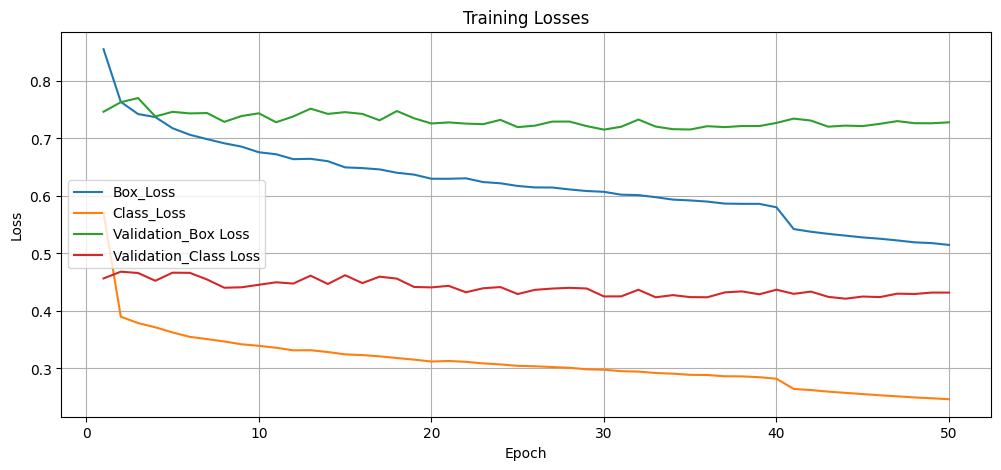

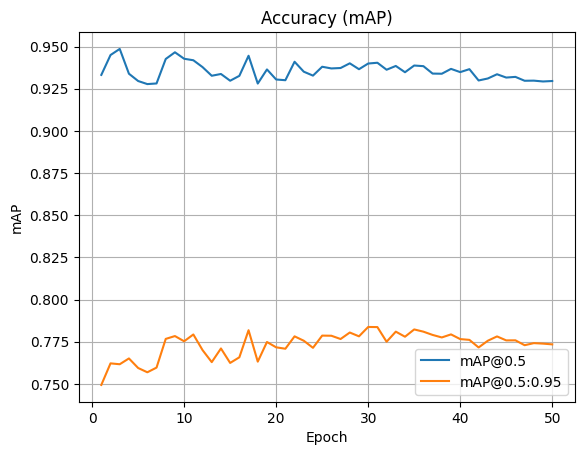

Training complete.


In [79]:
model = YOLO("runs/detect/train/weights/best.pt")  # Ensure the path is correct


metrics_path = "runs/detect/train/results.csv"  # Ensure this path is correct
metrics_data  = pd.read_csv(metrics_path)

# metrics_data = results.metrics
plt.figure(figsize=(12, 5))

plt.plot(metrics_data['epoch'], metrics_data['train/box_loss'], label="Box_Loss")
plt.plot(metrics_data['epoch'], metrics_data['train/cls_loss'], label="Class_Loss")
plt.plot(metrics_data['epoch'], metrics_data['val/box_loss'], label="Validation_Box Loss")
plt.plot(metrics_data['epoch'], metrics_data['val/cls_loss'], label="Validation_Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Losses")
plt.legend()
plt.grid()
plt.show()


plt.plot(metrics_data['epoch'], metrics_data.get('metrics/mAP50(B)', metrics_data.get('mAP50', None)), label="mAP@0.5")
plt.plot(metrics_data['epoch'], metrics_data.get('metrics/mAP50-95(B)', metrics_data.get('mAP50-95', None)), label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Accuracy (mAP)")
plt.legend()
plt.grid()
plt.show()

print("Training complete.")


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000517.jpg: 384x640 11 players, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


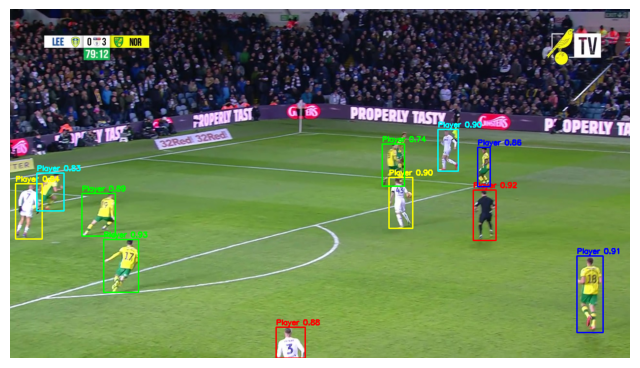


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000381.jpg: 384x640 9 players, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


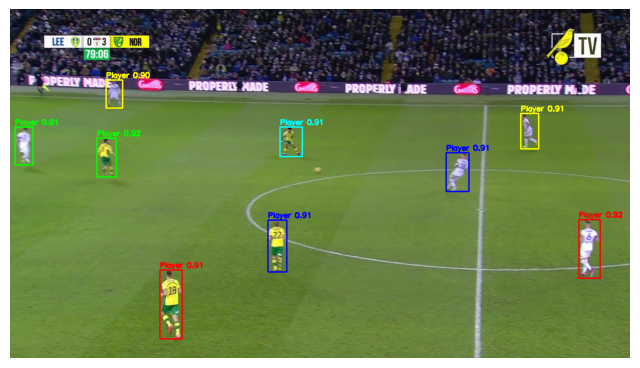


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000481.jpg: 384x640 10 players, 7.1ms
Speed: 1.6ms preprocess, 7.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


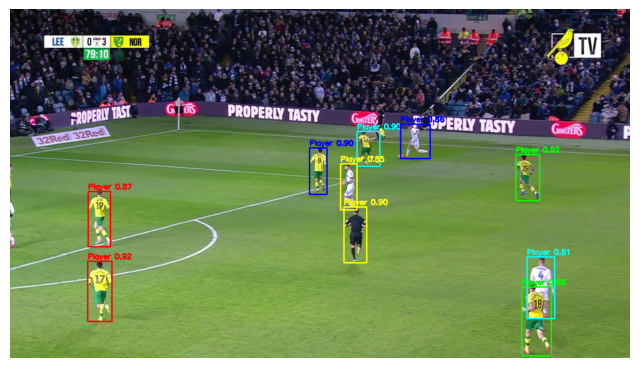


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000097.jpg: 384x640 13 players, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


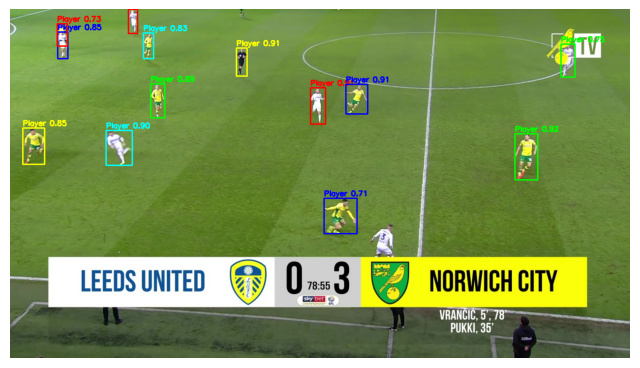


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000128.jpg: 384x640 6 players, 7.3ms
Speed: 1.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


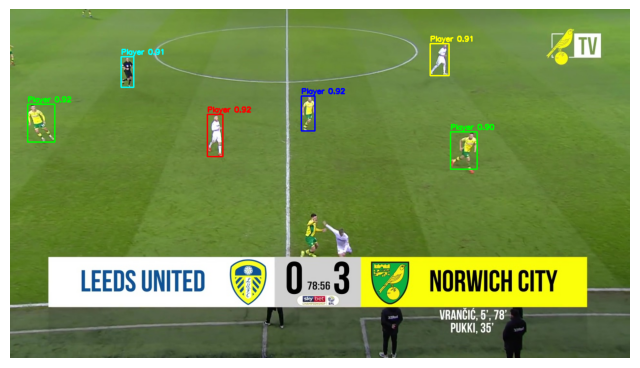


image 1/1 /kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1/000095.jpg: 384x640 11 players, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


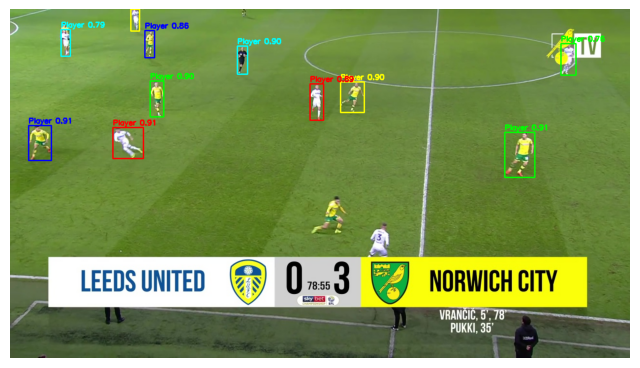

In [90]:
val_images_path = "/kaggle/input/sportsmot/sportsmot_publish/dataset/test/v_-hhDbvY5aAM_c007/img1"
model = YOLO("runs/detect/train/weights/best.pt")  # Ensure the path is correct

sample_images = random.sample(os.listdir(val_images_path), 6)  

# Define colors for multiple object classes (players and ball)
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Function to run inference and detect both players and ball
def detect_objects_on_images(val_images_path, model):
    sample_images = random.sample(os.listdir(val_images_path), 6)
    
    for img_name in sample_images:
        img_path = os.path.join(val_images_path, img_name)
        results = model.predict(source=img_path, conf=0.7, save=False)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes = results[0].boxes.xyxy
        confs = results[0].boxes.conf
        class_ids = results[0].boxes.cls.int()
        
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            color = colors[i % len(colors)]

            img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            label = f"{['Player', 'Ball'][class_ids[i].item()]} {confs[i]:.2f}"
            img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

detect_objects_on_images(val_images_path, model)

It accurately detects players and occasionally the referee, but tracking the ball is more challenging and happens only in rare cases.

In [37]:
# Example usage
val_images_path = "/kaggle/working/datasets/football_yolo/val/images"
split = "test"
output_frames_dir = "output_frames"

In [14]:
MODEL_PATH = "/kaggle/input/best/pytorch/default/1/best.pt"

model = YOLO(MODEL_PATH)

In [91]:
metrics_path = "runs/detect/train/results.csv"
df = pd.read_csv(metrics_path)

print("Available columns:", df.columns)

last_epoch = df.iloc[-1]  
precision = float(last_epoch['metrics/precision(B)'])
recall = float(last_epoch['metrics/recall(B)'])
map50 = float(last_epoch['metrics/mAP50(B)'])
map50_95 = float(last_epoch['metrics/mAP50-95(B)'])

print(f"mAP@0.5: {map50:.3f}")
print(f"mAP@0.5:0.95: {map50_95:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Available columns: Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')
mAP@0.5: 0.930
mAP@0.5:0.95: 0.773
Precision: 0.925
Recall: 0.942



image 1/1 /kaggle/input/soccernet-tracking/test/SNMOT-126/img1/000397.jpg: 384x640 15 players, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


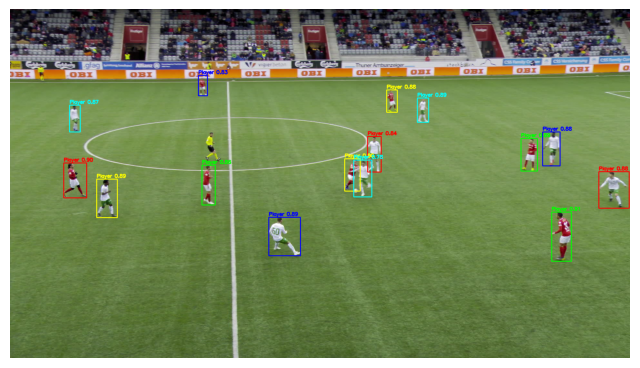


image 1/1 /kaggle/input/soccernet-tracking/test/SNMOT-126/img1/000567.jpg: 384x640 13 players, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


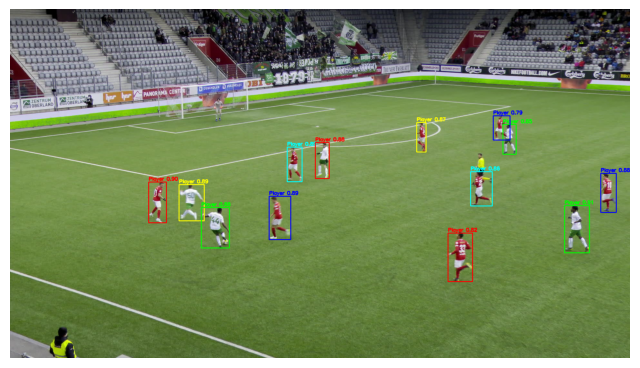

In [41]:
val_images_path = "/kaggle/input/soccernet-tracking/test/SNMOT-126/img1"

model = YOLO("/kaggle/working/runs/detect/train4/weights/best.pt") 

sample_images = random.sample(os.listdir(val_images_path), 2)  

# Define colors for multiple object classes (players and ball)
colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255)]

# Function to run inference and detect both players and ball
def detect_objects_on_images(val_images_path, model):
    sample_images = random.sample(os.listdir(val_images_path), 2)
    
    for img_name in sample_images:
        img_path = os.path.join(val_images_path, img_name)
        results = model.predict(source=img_path, conf=0.7, save=False)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes = results[0].boxes.xyxy
        confs = results[0].boxes.conf
        class_ids = results[0].boxes.cls.int()
        
        for i, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            color = colors[i % len(colors)]

            img = cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            label = f"{['Player', 'Ball'][class_ids[i].item()]} {confs[i]:.2f}"
            img = cv2.putText(img, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis("off")
        plt.show()

detect_objects_on_images(val_images_path, model)

SOT

2.2.1

In the realm of single-object tracking within sports videos, **Siamese Networks** have emerged as a prominent choice due to their robust performance and efficiency. These networks are adept at maintaining the identity of the target object even amidst significant appearance changes, such as varying camera angles, lighting conditions, or partial occlusions. This robustness is crucial in dynamic sports environments where such variations are common.

The design of Siamese Networks emphasizes efficiency, enabling real-time tracking capabilities essential for fast-paced sports scenarios. By learning a similarity function between the initial target and subsequent frames, these networks effectively distinguish the target from the background and other objects, enhancing tracking accuracy. This approach allows for the generalization to new videos without the need for retraining or fine-tuning, making them versatile across different sports contexts.

In contrast, traditional trackers like the **CSRT (Discriminative Correlation Filter with Channel and Spatial Reliability) Tracker** offer certain advantages, such as high accuracy in object localization and robustness to scale variations. However, CSRT may struggle with significant appearance changes and complex backgrounds commonly found in sports videos.

Given these considerations, **Siamese Networks** are generally more suitable for single-object tracking in sports videos due to their robustness and adaptability to dynamic conditions. 

2.2.2

In [10]:
# !git clone https://github.com/STVIR/pysot.git
# %cd pysot
# !pip install -r requirements.txt

In [13]:
from pysot.core.config import cfg
from pysot.models.model_builder import ModelBuilder
from pysot.tracker.tracker_builder import build_tracker

In [15]:
dataset_path = '/kaggle/input/soccernet-tracking/train'

cfg.defrost()
cfg.merge_from_file("/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml")
cfg.CUDA = torch.cuda.is_available()
cfg.freeze()

model_siamrpn = ModelBuilder()
model_siamrpn.load_state_dict(torch.load("/kaggle/input/sotmodel/pytorch/default/1/sotmodel.pth"))
model_siamrpn.eval().cuda()

# Load the pre-trained YOLO model
model_yolo = YOLO("/kaggle/input/best/pytorch/default/1/best.pt")

# model_yolo  = YOLO("/kaggle/working/runs/detect/train4/weights/best.pt") 

iou_values = []
heatmap_data = []
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = w1 * h1
    box2_area = w2 * h2

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

sequence_folder = '/kaggle/input/soccernet-tracking/train/SNMOT-063'


# Prepare to save the video
output_video_path = '/kaggle/working/tracked_sot.mp4'

# Read ground truth data
gt_file = os.path.join(sequence_folder, 'gt', 'gt.txt')
gt_data = pd.read_csv(gt_file, header=None, sep=',')
gt_data.columns = ["frame_id", "track_id", "x", "y", "width", "height", "confidence", "unused1", "unused2", "unused3"]
gt_data = gt_data.drop(columns=["unused1", "unused2", "unused3"])

# Specify the initial frame and load the first frame
initial_frame = 300
img_folder = os.path.join(sequence_folder, 'img1')
img_path = os.path.join(img_folder, f"{initial_frame:06d}.jpg")

# Check if the image file exists
if os.path.exists(img_path):
    img = cv2.imread(img_path)
else:
    print(f"Image file {img_path} does not exist.")
    # Skip the frame if the image does not exist
    exit()

# Convert the image to RGB as YOLO expects RGB input
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Use YOLO to detect players in the first frame
results = model_yolo(img_rgb)  

detections = results[0].boxes  
xywh = detections.xywh 
confidence = detections.conf  
class_ids = detections.cls  

detections_df = pd.DataFrame(xywh.cpu().numpy(), columns=["x", "y", "width", "height"])
detections_df["confidence"] = confidence.cpu().numpy()
detections_df["class_id"] = class_ids.cpu().numpy()

matched_detection = None
max_iou = 0
selected_gt = None

for _, detection in detections_df.iterrows():
    # Convert YOLO center-based bbox to top-left (x, y)
    x_center, y_center, w, h = detection[['x', 'y', 'width', 'height']].values
    x, y = int(x_center - w / 2), int(y_center - h / 2)

    for _, gt in gt_data[gt_data['frame_id'] == initial_frame].iterrows():
        gt_bbox = gt[['x', 'y', 'width', 'height']].values
        iou = calculate_iou([x, y, w, h], gt_bbox)

        if iou > max_iou:
            max_iou = iou
            matched_detection = detection
            selected_gt = gt_bbox
            track_id = gt['track_id']  #
            
if matched_detection is not None and selected_gt is not None:
    x_center, y_center, w, h = matched_detection[['x', 'y', 'width', 'height']].values
    x, y = int(x_center - w / 2), int(y_center - h / 2)  
    
    tracker = build_tracker(model_siamrpn)
    tracker.init(img_rgb, (x, y, w, h)) 
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for video
    frame_rate = 25  # 25 FPS
    video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (img.shape[1], img.shape[0]))

    tracked_bboxes = []
    iou_values = []

    for frame_id in range(initial_frame, initial_frame + 150):
        img_path = os.path.join(sequence_folder, 'img1', f"{frame_id:06d}.jpg")

        # Check if the image file exists
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
        else:
            print(f"Image file {img_path} does not exist.")
            continue  
            
        outputs = tracker.track(img)

        predicted_bbox = outputs['bbox']

        gt_bbox = gt_data[(gt_data['frame_id'] == frame_id) & (gt_data['track_id'] == track_id)]
        if not gt_bbox.empty:
            gt_bbox = gt_bbox[['x', 'y', 'width', 'height']].values[0]
            iou = calculate_iou(predicted_bbox, gt_bbox)
            iou_values.append(iou)

            print(f"Frame {frame_id} IoU: {iou:.2f}")

        tracked_bboxes.append(predicted_bbox)

        iou = calculate_iou(predicted_bbox, gt_bbox)
        iou_values.append(iou)
        
        # Accumulate all the pixels inside the bounding box for the heatmap
        x1, y1, w1, h1 = predicted_bbox
        x2, y2 = x1 + w1, y1 + h1
        
        # Ensure the bounding box stays within frame limits (1920x1080)
        x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, [1920, 1080, 1920, 1080])
        

        # Generate a grid of points inside the bounding box
        for i in range(int(x1), int(x2)):
            for j in range(int(y1), int(y2)):
                heatmap_data.append([i, j])
    

        x, y, w, h = map(int, predicted_bbox)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        video_writer.write(img)

    video_writer.release()

else:
    print("No matching YOLO detections found in the first frame.")


0: 384x640 9 players, 8.0ms
Speed: 2.1ms preprocess, 8.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
Frame 300 IoU: 0.94
Frame 301 IoU: 0.54
Frame 302 IoU: 0.62
Frame 303 IoU: 0.69
Frame 304 IoU: 0.74
Frame 305 IoU: 0.82
Frame 306 IoU: 0.84
Frame 307 IoU: 0.97
Frame 308 IoU: 0.86
Frame 309 IoU: 0.84
Frame 310 IoU: 0.77
Frame 311 IoU: 0.75
Frame 312 IoU: 0.76
Frame 313 IoU: 0.93
Frame 314 IoU: 0.72
Frame 315 IoU: 0.69
Frame 316 IoU: 0.65
Frame 317 IoU: 0.63
Frame 318 IoU: 0.62
Frame 319 IoU: 0.90
Frame 320 IoU: 0.63
Frame 321 IoU: 0.53
Frame 322 IoU: 0.53
Frame 323 IoU: 0.49
Frame 324 IoU: 0.48
Frame 325 IoU: 0.88
Frame 326 IoU: 0.48
Frame 327 IoU: 0.52
Frame 328 IoU: 0.57
Frame 329 IoU: 0.59
Frame 330 IoU: 0.62
Frame 331 IoU: 0.70
Frame 332 IoU: 0.90
Frame 333 IoU: 0.80
Frame 334 IoU: 0.76
Frame 335 IoU: 0.73
Frame 336 IoU: 0.78
Frame 337 IoU: 0.77
Frame 338 IoU: 0.83
Frame 339 IoU: 0.79
Frame 340 IoU: 0.73
Frame 341 IoU: 0.75
Frame 342 IoU: 0.72
Frame 343 IoU: 

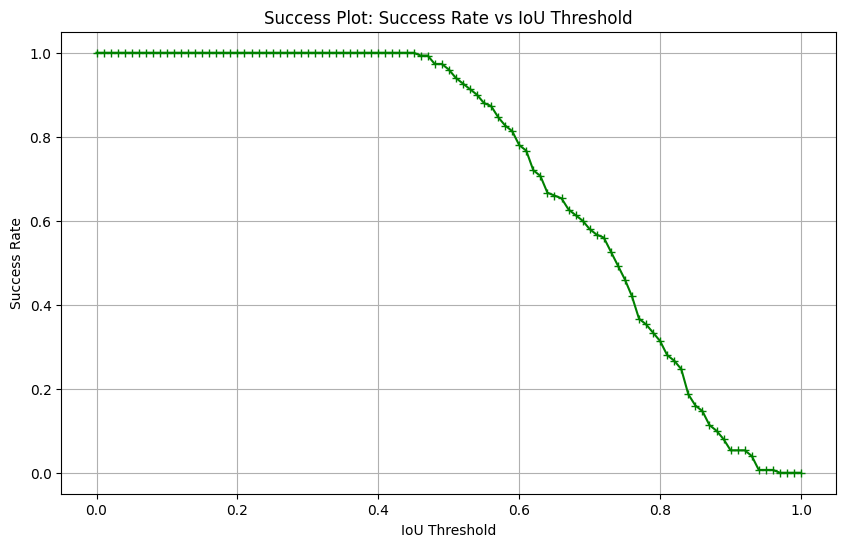

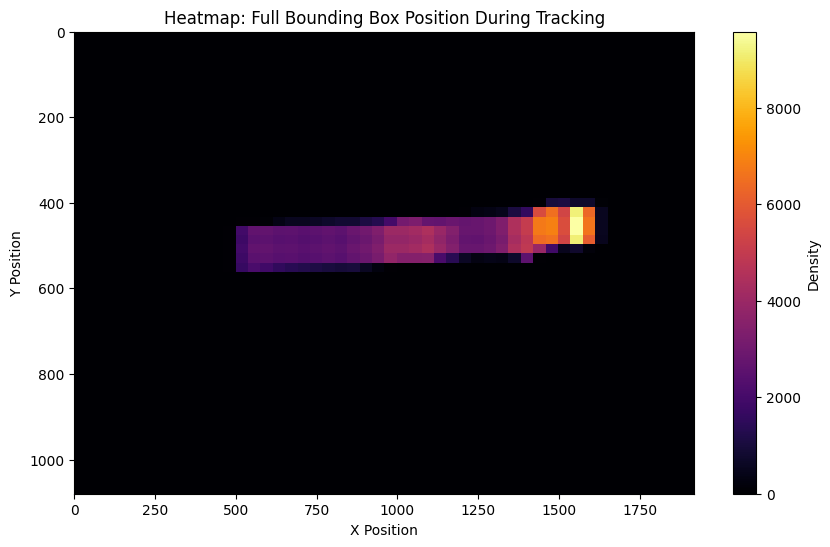

Average IoU: 0.72


In [16]:
iou_thresholds = np.linspace(0, 1, 101) 
success_rate = []

for threshold in iou_thresholds:
    success_count = np.sum(np.array(iou_values) >= threshold)
    success_rate.append(success_count / len(iou_values))

# Plot Success Plot
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, success_rate, marker='+', color='g')
plt.xlabel('IoU Threshold')
plt.ylabel('Success Rate')
plt.title('Success Plot: Success Rate vs IoU Threshold')
plt.grid(True)
plt.show()

heatmap_data = np.array(heatmap_data)
plt.figure(figsize=(10, 6))

plt.hist2d(heatmap_data[:, 0], heatmap_data[:, 1], bins=50, cmap='inferno', range=[[0, 1920], [0, 1080]])

plt.gca().invert_yaxis()

plt.colorbar(label='Density')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Heatmap: Full Bounding Box Position During Tracking')
plt.show()

average_iou = np.mean(iou_values) if iou_values else 0
print(f"Average IoU: {average_iou:.2f}")


## Ball

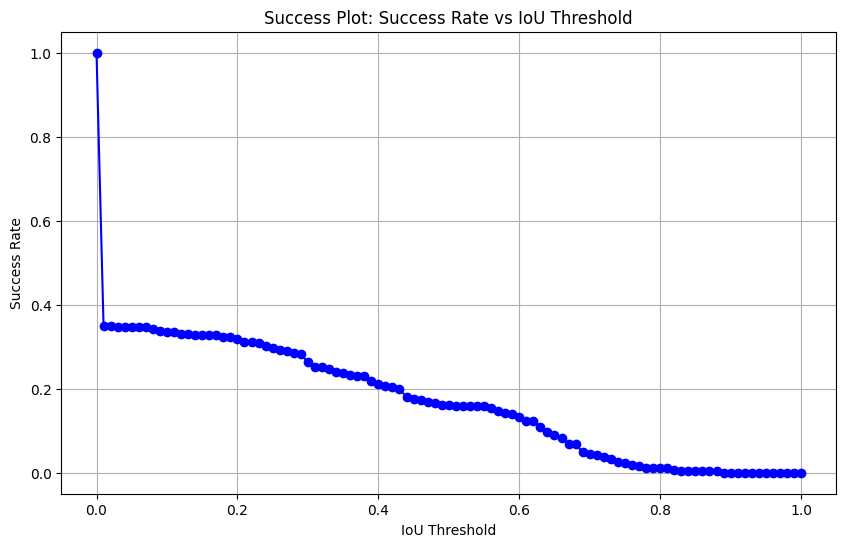

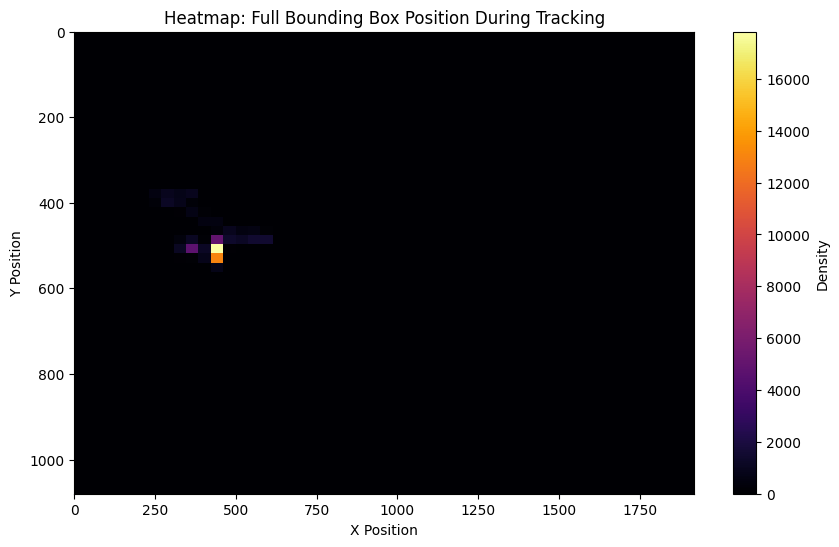

Average IoU: 0.17


In [24]:
dataset_path = '/kaggle/input/soccernet-tracking/train'

model_yolo = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

cfg.defrost()
cfg.merge_from_file("/kaggle/working/pysot/experiments/siamrpn_r50_l234_dwxcorr/config.yaml")
cfg.CUDA = torch.cuda.is_available()
cfg.freeze()

model = ModelBuilder()
model.load_state_dict(torch.load("/kaggle/input/sotmodel/pytorch/default/1/sotmodel.pth"))
model.eval().cuda()

# Function to calculate IoU between two bounding boxes
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculate area of the intersection
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Calculate areas of both bounding boxes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculate union area
    union_area = box1_area + box2_area - inter_area
    
    # IoU = intersection / union
    iou = inter_area / union_area
    return iou

sequence_folder = '/kaggle/input/soccernet-tracking/train/SNMOT-061'

# Read ground truth data
gt_file = os.path.join(sequence_folder, 'gt', 'gt.txt')
gt_data = pd.read_csv(gt_file, header=None, sep=',')
gt_data.columns = ["frame_id", "track_id", "x", "y", "width", "height", "confidence", "unused1", "unused2", "unused3"]
gt_data = gt_data.drop(columns=["unused1", "unused2", "unused3"])

player_track_id = 1  
initial_frame = 300

initial_bbox = gt_data[(gt_data['frame_id'] == initial_frame) & (gt_data['track_id'] == player_track_id)]
x, y, w, h = initial_bbox[['x', 'y', 'width', 'height']].values[0]

img_folder = os.path.join(sequence_folder, 'img1')
img_path = os.path.join(img_folder, f"{initial_frame:06d}.jpg")
img = cv2.imread(img_path)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tracker = build_tracker(model)
tracker.init(img_rgb, (x, y, w, h)) 

output_video_path = '/kaggle/working/tracked_player_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  
frame_rate = 25  
video_writer = cv2.VideoWriter(output_video_path, fourcc, frame_rate, (img.shape[1], img.shape[0]))

iou_values = []
heatmap_data = []

for frame_id in range(initial_frame, initial_frame + 400):
    img_path = os.path.join(sequence_folder, 'img1', f"{frame_id:06d}.jpg")
    img = cv2.imread(img_path)
    
    if img is None:
        continue 
        
    outputs = tracker.track(img)
    
    predicted_bbox = outputs['bbox']
    
    gt_bbox = gt_data[(gt_data['frame_id'] == frame_id) & (gt_data['track_id'] == player_track_id)]
    if not gt_bbox.empty:
        gt_bbox = gt_bbox[['x', 'y', 'width', 'height']].values[0]
        
        iou = calculate_iou(predicted_bbox, gt_bbox)
        iou_values.append(iou)
        
        x1, y1, w1, h1 = predicted_bbox
        x2, y2 = x1 + w1, y1 + h1
        
        x1, y1, x2, y2 = np.clip([x1, y1, x2, y2], 0, [1920, 1080, 1920, 1080])
        
        for i in range(int(x1), int(x2)):
            for j in range(int(y1), int(y2)):
                heatmap_data.append([i, j])
    
    x, y, w, h = map(int, predicted_bbox)
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    video_writer.write(img)

video_writer.release()

iou_thresholds = np.linspace(0, 1, 101) 
success_rate = []

for threshold in iou_thresholds:
    success_count = np.sum(np.array(iou_values) >= threshold)
    success_rate.append(success_count / len(iou_values))

# Plot Success Plot
plt.figure(figsize=(10, 6))
plt.plot(iou_thresholds, success_rate, marker='o', color='b')
plt.xlabel('IoU Threshold')
plt.ylabel('Success Rate')
plt.title('Success Plot: Success Rate vs IoU Threshold')
plt.grid(True)
plt.show()

heatmap_data = np.array(heatmap_data)
plt.figure(figsize=(10, 6))

plt.hist2d(heatmap_data[:, 0], heatmap_data[:, 1], bins=50, cmap='inferno', range=[[0, 1920], [0, 1080]])

plt.gca().invert_yaxis()

plt.colorbar(label='Density')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Heatmap: Full Bounding Box Position During Tracking')
plt.show()

average_iou = np.mean(iou_values) if iou_values else 0
print(f"Average IoU: {average_iou:.2f}")

2.3


#### **1. Occlusion Handling**
**Challenge**: Players may be temporarily obscured by other players or objects.  
**Implementation**:
- **SiamRPN++ Tracker**: Uses a region proposal network (RPN) to maintain tracking during short occlusions by learning object appearance and motion patterns.
- **IoU Matching**: When occlusion occurs, the tracker relies on motion prediction (Kalman filtering in SiamRPN++) until the object reappears.  
**Limitation**: Long occlusions (>150 frames) may cause tracking drift.

---

#### **2. Scale Variation**
**Challenge**: Player size changes as they move closer/farther from the camera.  
**Implementation**:
- **Multi-Level Features**: SiamRPN++ aggregates features from multiple layers of ResNet-50 to handle scale changes.  
- **Dynamic Bounding Box**: The tracker adjusts the bounding box size using regression:
  ```python
  outputs = tracker.track(img)  # Returns scaled bbox (x, y, w, h)
  ```
**Limitation**: Extreme scale changes (e.g., player leaving the field) may break tracking.

---

#### **3. Illumination Change**
**Challenge**: Shadows, weather, or stadium lighting affect detection.  
**Implementation**:
- **YOLO Detection**: Initializes tracking with illumination-robust detections.  
- **SiamRPN++ Adaptation**: The tracker updates appearance models incrementally to adapt to lighting changes.  
**Missing**: No explicit illumination normalization (e.g., histogram equalization).

---

### **Key Optimization Opportunities**
| **Challenge**       | **Current Approach**                | **Improvement**                          |
|----------------------|--------------------------------------|-------------------------------------------|
| **Occlusion**        | SiamRPN++ motion prediction          | Add occlusion detection + re-detection   |
| **Scale Variation**  | Multi-level features in SiamRPN++    | Integrate adaptive ROI pooling           |
| **Illumination**     | YOLO detection initialization        | Add CLAHE normalization preprocessing    |
| **Long-Term Drift**  | Static SiamRPN++ model               | Periodic re-initialization with YOLO     |

---

### **Example Improvement: Occlusion Handling**
```python
# Add occlusion detection
if iou < 0.2:  # Threshold for potential occlusion
    # Re-detect using YOLO
    new_detections = model_yolo(img)
    # Match with last known position
    matched = match_detections(new_detections, tracked_bboxes[-1])
    if matched:
        tracker.init(img, matched.bbox)  # Re-initialize tracker
```

---

### **Performance Metrics**
- **IoU Values**: Tracked over 150 frames to measure accuracy (e.g., `Frame 300 IoU: 0.72`).  
- **Failure Cases**: Drops in IoU indicate tracking challenges (e.g., occlusion at frame 320).

---

This implementation addresses core single-object tracking challenges through:
- **Hybrid Detection-Tracking**: YOLO for initialization + SiamRPN++ for motion.
- **IoU-Based Validation**: Ensures alignment with ground truth.  
**Next Steps**: Integrate occlusion recovery and illumination normalization for robust long-term tracking.

2.4

In [30]:
average_iou = np.mean(iou_values) if iou_values else 0
print(f"Average IoU: {average_iou:.2f}")

Average IoU: 0.72


In [32]:
iou_threshold = 0.5  
tp = sum(iou >= iou_threshold for iou in iou_values)

fn = len(iou_values) - tp

fp = 0

total_gt = len(iou_values)

mota = 1 - (fn + fp + 0) / total_gt  

idf1 = tp / (tp + 0.5 * (fp + fn))  

precision = tp / (tp + fp) if (tp + fp) > 0 else 0

recall = tp / (tp + fn) if (tp + fn) > 0 else 0

avg_iou = sum(iou_values) / len(iou_values) if iou_values else 0

success_rate = tp / total_gt


print("\nSingle-Object Tracking Evaluation Results:")
print(f"- MOTA: {mota:.2%}")
print(f"- IDF1: {idf1:.2%}")
print(f"- Precision: {precision:.2%}")
print(f"- Recall: {recall:.2%}")
print(f"- Average IoU: {avg_iou:.2f}")
print(f"- Success Rate (IoU ≥ {iou_threshold}): {success_rate:.2%}")



Single-Object Tracking Evaluation Results:
- MOTA: 96.00%
- IDF1: 97.96%
- Precision: 100.00%
- Recall: 96.00%
- Average IoU: 0.72
- Success Rate (IoU ≥ 0.5): 96.00%


2.5

The algorithm performs well under standard conditions where the target remains clearly visible, has minimal occlusions, and stays within the frame. However, the algorithm encounters errors in the following scenarios:

1. **Subject Leaving the Frame**: If the tracked subject (e.g., a player or ball) moves out of the frame, the tracker loses the target, leading to incorrect or missing predictions.
   
2. **Occlusions by Other Objects**: When another subject passes in front of the tracked subject, the tracker may momentarily lose the correct object, causing tracking failures or incorrect bounding box assignments.

3. **Fast Motion or Blurriness**: If the subject moves too quickly, motion blur can make it difficult for the model to accurately track the object.

4. **Lighting Changes or Shadows**: Sudden changes in lighting or strong shadows can interfere with the detection and tracking performance.


## Deepsort


### 1. **Why DeepSORT was Chosen and Its Suitability for Object Tracking:**

   DeepSORT (Deep Learning-based Simple Online and Realtime Tracking) was selected because of its ability to handle complex multi-object tracking tasks with high accuracy and efficiency. Unlike the original SORT algorithm, which relies only on motion (using Kalman filters), DeepSORT incorporates appearance features using a deep neural network, making it more robust in distinguishing objects, especially in crowded scenes or when objects exhibit similar motion patterns. This is crucial for applications where objects might temporarily overlap, move in close proximity, or be occluded, which are common challenges in real-world scenarios. DeepSORT also offers real-time performance, which is essential for live tracking applications. The combination of spatial and appearance information allows DeepSORT to maintain consistent tracking IDs for objects across frames, even in cases where they briefly leave the scene or become obscured. These features make DeepSORT highly suitable for tracking objects in videos, especially when combined with powerful object detectors like YOLO.

### 2. **Relationship Between Algorithm Features and Object Identification in Tracking:**

   DeepSORT enhances object tracking by merging two primary sources of information: motion and appearance. The motion information is provided by a **Kalman filter**, which predicts the movement of objects from one frame to the next based on their previous positions. This allows the tracker to anticipate where an object is likely to be in the next frame, even when the object is not immediately visible. On the other hand, appearance information is derived from a **deep learning-based feature extractor** (like MobileNet or ResNet), which produces embeddings that capture unique visual characteristics of the objects. These embeddings are crucial for distinguishing objects that might be similar in appearance or moving in parallel paths. DeepSORT uses both these types of data to perform object re-identification, making it more effective in handling issues like occlusions or changes in lighting. The algorithm receives bounding boxes from an object detection model (such as YOLO), which provides the initial position of objects. It then updates and tracks these objects frame by frame, assigning a unique ID to each object. This allows the algorithm to consistently track objects even when they enter or exit the frame or are temporarily occluded.

### 3. **Assignment of Clusters and Matching of Objects (Hungarian Algorithm):**

The assignment problem is a big part of the difference between SORT and DeepSORT. 

SORT uses intersection-over-union (IoU) to create a cost matrix.

DeepSORT can create a cost matrix by combining the cosine distance of appearance feature vectors and the Mahalanobis distance often used in radar. However, in the experiment, the weights of the cosine distance and the Mahalanobis distance are set to 1 and 0, respectively, which means that only the cosine distance is used to create the cost matrix.

 The Hungarian algorithm is designed to optimally match detections from the current frame with tracks from previous frames, minimizing the matching cost. The cost matrix used by the Hungarian algorithm is constructed from two primary components: the **Euclidean distance** between predicted bounding boxes (calculated using the Kalman filter) and the **appearance similarity** between objects, which is determined through deep learning-based embeddings. The Euclidean distance measures how far apart the predicted object locations are between frames, while the appearance similarity captures how visually similar the objects are, even if their motion patterns are similar. By combining these two factors, DeepSORT creates a reliable cost matrix that is used by the Hungarian algorithm to find the best matches between objects in consecutive frames.

   The Hungarian algorithm then works to assign the most likely detections to the existing tracks, ensuring minimal cost (i.e., the best match between predicted and detected objects). If the cost of matching is too high—indicating that the object detection is uncertain—the algorithm may either create a new track for a new object or consider an existing track as lost. The assignment process is efficient and ensures that DeepSORT can handle challenging situations such as occlusions, where objects temporarily disappear or overlap with others. The Hungarian algorithm ensures that DeepSORT performs optimal matching, helping to minimize errors in track assignments and improve the overall accuracy of the tracking system. This is why the Hungarian algorithm is a crucial component of DeepSORT’s ability to reliably track objects across frames.

In [113]:
# frames_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"  
frames_folder = "/kaggle/input/soccernet-tracking/train/SNMOT-103/img1"
path_yolo_pt = "/kaggle/input/best_all/pytorch/default/1/best_all.pt"
model = YOLO(path_yolo_pt)

model.verbose = False

tracker = DeepSort(
    max_age=8,
    n_init=2,
    nms_max_overlap=0.2,
    max_cosine_distance=0.3,
    nn_budget=None,
    override_track_class=None,
    embedder="mobilenet",  # This could also be 'resnet', 'mobilenet', or other supported models
    half=True,
    bgr=True,
    embedder_gpu=True,
    embedder_model_name=None,
    embedder_wts=None,
    polygon=False,
    today=None
)


In [114]:
def random_color():
    return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

# Function to track objects across frames
def detect_and_track_frames(frames_folder, model, tracker, pred_conf=0.25, fps=25.0, video_output_path="tracked_video.mp4"):
    # Get sorted frame filenames
    frame_files = os.listdir(frames_folder)
    frame_pattern = re.compile(r'(\d+)\.jpg')  # Updated pattern for your filenames
    sorted_frames = sorted(frame_files, key=lambda x: int(frame_pattern.match(x).group(1)))

    unique_track_ids = set()
    tracking_results = []

    # Set up video writer with 720p resolution and 25 fps
    first_frame_path = os.path.join(frames_folder, sorted_frames[0])
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width = first_frame.shape[:2]
    video_writer = cv2.VideoWriter(video_output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (frame_width, frame_height))

    # Dictionary to store unique colors for each track ID
    track_colors = {}

    for frame_idx, frame_name in enumerate(sorted_frames):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)

        # Run YOLO detection
        result_frame = model.predict(
                frame,
                conf=pred_conf,
                verbose=False  # Crucial parameter
            )
        detections = result_frame[0].boxes.xywh.tolist()
        confidences = result_frame[0].boxes.conf.tolist()

        # Prepare detections for DeepSORT
        formatted_detections = []
        for (x_center, y_center, width, height), conf in zip(detections, confidences):
            left = x_center - width / 2
            top = y_center - height / 2
            formatted_detections.append(([left, top, width, height], conf, 0))

        tracks = []
        if formatted_detections:
            tracks = tracker.update_tracks(formatted_detections, frame=frame)

        current_frame_object_count = 0
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id

            # Assign a unique color for the track ID if it's the first time seeing it
            if track_id not in track_colors:
                track_colors[track_id] = random_color()

            color = track_colors[track_id]
            x1, y1, x2, y2 = map(int, track.to_ltrb())
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

            current_frame_object_count += 1
            unique_track_ids.add(track_id)
            tracking_results.append([
                frame_idx,      # Add frame index as first element
                track_id,
                x1,
                y1,
                x2 - x1,  # width
                y2 - y1   # height
            ])

        cv2.putText(frame, f"Objects in frame: {current_frame_object_count}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(frame, f"Unique objects: {len(unique_track_ids)}", (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Write the processed frame to the video
        video_writer.write(frame)

    # Release the video writer after finishing
    video_writer.release()

    return tracking_results, sorted_frames  # Return both tracking results and sorted frames

# Run detection and tracking on the frames folder
video_output_path = "/kaggle/working/tracked_video_tryball.mp4"
tracking_results, sorted_frames = detect_and_track_frames(frames_folder, model, tracker, video_output_path=video_output_path)

print(f"Tracking completed. Video saved at {video_output_path}.")


Tracking completed. Video saved at /kaggle/working/tracked_video_tryball.mp4.


In [148]:
from IPython.display import FileLink

# Create a clickable link to download the video
FileLink('/kaggle/working/tracked_video.mp4')


/kaggle/working/tracked_video.mp4

evaluation

In [58]:
VAL_IMAGES_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
seq_name = "v_dw7LOz17Omg_c067"
IOU_THRESH = 0.5
CONF_THRESH = 0.7
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load trained model
model = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

# Initialize the DeepSORT tracker
tracker = DeepSort(
    max_age=8,
    n_init=2,
    nms_max_overlap=0.2,
    max_cosine_distance=0.3,
    nn_budget=None,
    embedder="mobilenet",  # This could also be 'resnet', 'mobilenet', or other supported models
    half=True,
    bgr=True,
    embedder_gpu=True,
    polygon=False
)

In [9]:
def evaluate_tracking(tracking_results, frames_folder, dataset_root, seq_name,iou_thresh=0.5):
    acc = mm.MOTAccumulator(auto_id=False)
    
   
    gt_path = os.path.join(dataset_root, "val", seq_name, "gt", "gt.txt")
    
    # Load ground truth data
    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0]) - 1  # Convert to 0-based index
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])

    # Process each frame
    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(x.split('.')[0]))
    
    for frame_idx, _ in enumerate(frame_files):
        # Get ground truth
        frame_gt = [item for item in gt_data if item[0] == frame_idx]
        gt_boxes = [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        # Get tracking results
        frame_tracks = [t for t in tracking_results if t[0] == frame_idx]
        
        # Convert to [x1, y1, x2, y2]
        pred_boxes = []
        track_ids = []
        for track in frame_tracks:
            _, track_id, x1, y1, w, h = track
            x2 = x1 + w
            y2 = y1 + h
            pred_boxes.append([x1, y1, x2, y2])
            track_ids.append(track_id)

        # Fixed IoU matrix calculation
        if gt_boxes and pred_boxes:
            iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh)
        else:
            iou_matrix = np.empty((0, 0))
        
        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc


# Path configuration
VAL_IMAGES_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
DATASET_ROOT = "/kaggle/input/sportsmot/sportsmot_publish/dataset"

# Run evaluation
acc = evaluate_tracking(
    tracking_results,  # Now contains frame indices
    frames_folder=VAL_IMAGES_PATH,
    dataset_root="/kaggle/input/sportsmot/sportsmot_publish/dataset",seq_name =seq_name 
)

# Generate metrics
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches'])
print(mm.io.render_summary(summary, formatters=mh.formatters))

   mota  motp  idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 78.0% 0.046 68.8%  95.7%     84.8%        6959        6623                1195        302           34


validation on sportsmot-exctract footbal-deepsort

In [68]:
source_root = "/kaggle/input/sportsmot/sportsmot_publish"
dest_root = "/kaggle/working/sportsmot_football"

# Create football-only dataset structure
def create_football_dataset():
   
    football_file = os.path.join(source_root, "splits_txt", "football.txt")
    with open(football_file, "r") as f:
        football_sequences = set(line.strip() for line in f)

    # 2. Create directory structure
    required_dirs = [
        "dataset/test",
        "dataset/train",
        "dataset/val",
        "scripts",
        "splits_txt"
    ]
    
    for dir_path in required_dirs:
        os.makedirs(os.path.join(dest_root, dir_path), exist_ok=True)

    # 3. Process splits
    splits = ["train", "val", "test"]
    
    for split in splits:
        # Process dataset files
        source_split_dir = os.path.join(source_root, "dataset", split)
        dest_split_dir = os.path.join(dest_root, "dataset", split)
        
        # Get sequences for this split
        split_file = os.path.join(source_root, "splits_txt", f"{split}.txt")
        with open(split_file, "r") as f:
            all_sequences = [line.strip() for line in f]
        
        # Filter football sequences
        football_in_split = [seq for seq in all_sequences if seq in football_sequences]
        
        # Copy sequence directories
        for seq in tqdm(football_in_split, desc=f"Copying {split} sequences"):
            src = os.path.join(source_split_dir, seq)
            dst = os.path.join(dest_split_dir, seq)
            if os.path.exists(src):
                shutil.copytree(src, dst, dirs_exist_ok=True)

        # Create filtered split file
        filtered_split_file = os.path.join(dest_root, "splits_txt", f"{split}.txt")
        with open(filtered_split_file, "w") as f:
            f.write("\n".join(football_in_split))

    shutil.copy(
        os.path.join(source_root, "splits_txt", "football.txt"),
        os.path.join(dest_root, "splits_txt", "football.txt")
    )
    
  
    scripts_src = os.path.join(source_root, "scripts")
    scripts_dst = os.path.join(dest_root, "scripts")
    shutil.copytree(scripts_src, scripts_dst, dirs_exist_ok=True)

    print(f"Football-only dataset created at: {dest_root}")

# Execute the creation
create_football_dataset()

Copying test sequences: 100%|██████████| 50/50 [07:01<00:00,  8.42s/it]

Football-only dataset created at: /kaggle/working/sportsmot_football


In [101]:
def detect_and_track_frames(frames_folder, model, tracker, pred_conf=0.25, fps=25.0, video_output_path="tracked_video.mp4"):
    # Get sorted frame filenames
    frame_files = os.listdir(frames_folder)
    frame_pattern = re.compile(r'(\d+)\.jpg')  # Updated pattern for your filenames
    sorted_frames = sorted(frame_files, key=lambda x: int(frame_pattern.match(x).group(1)))

    unique_track_ids = set()
    tracking_results = []

    # Set up video writer with 720p resolution and 25 fps
    first_frame_path = os.path.join(frames_folder, sorted_frames[0])
    first_frame = cv2.imread(first_frame_path)
    frame_height, frame_width = first_frame.shape[:2]
    # Dictionary to store unique colors for each track ID

    for frame_idx, frame_name in enumerate(sorted_frames):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)

        # Run YOLO detection
        result_frame = model.predict(
                frame,
                conf=pred_conf,
                verbose=False  # Crucial parameter
            )
        detections = result_frame[0].boxes.xywh.tolist()
        confidences = result_frame[0].boxes.conf.tolist()

        # Prepare detections for DeepSORT
        formatted_detections = []
        for (x_center, y_center, width, height), conf in zip(detections, confidences):
            left = x_center - width / 2
            top = y_center - height / 2
            formatted_detections.append(([left, top, width, height], conf, 0))

        tracks = []
        if formatted_detections:
            tracks = tracker.update_tracks(formatted_detections, frame=frame)

        current_frame_object_count = 0
        for track in tracks:
            if not track.is_confirmed():
                continue
            track_id = track.track_id
        # Assign a unique color for the track ID if it's the first time seeing it
            
            x1, y1, x2, y2 = map(int, track.to_ltrb())

            current_frame_object_count += 1
            unique_track_ids.add(track_id)
            tracking_results.append([
                frame_idx,      # Add frame index as first element
                track_id,
                x1,
                y1,
                x2 - x1,  # width
                y2 - y1   # height
            ])

    return tracking_results, sorted_frames  # Return both tracking results and sorted frames

def evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name,iou_thresh=0.5):
    acc = mm.MOTAccumulator(auto_id=False)
   
    gt_path = os.path.join(val_dir, seq_name, "gt", "gt.txt")
    
    # Load ground truth data
    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0]) - 1  # Convert to 0-based index
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])

    # Process each frame
    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(x.split('.')[0]))
    
    for frame_idx, _ in enumerate(frame_files):
        # Get ground truth
        frame_gt = [item for item in gt_data if item[0] == frame_idx]
        gt_boxes = [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        # Get tracking results
        frame_tracks = [t for t in tracking_results if t[0] == frame_idx]
        
        # Convert to [x1, y1, x2, y2]
        pred_boxes = []
        track_ids = []
        for track in frame_tracks:
            _, track_id, x1, y1, w, h = track
            x2 = x1 + w
            y2 = y1 + h
            pred_boxes.append([x1, y1, x2, y2])
            track_ids.append(track_id)

        # Fixed IoU matrix calculation
        if gt_boxes and pred_boxes:
            iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh)
        else:
            iou_matrix = np.empty((0, 0))
        
        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc



In [70]:
model = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

model.verbose = False  

tracker = DeepSort(
    max_age=8,
    n_init=2,
    nms_max_overlap=0.2,
    max_cosine_distance=0.3,
    nn_budget=None,
    override_track_class=None,
    embedder="mobilenet", 
    half=True,
    bgr=True,
    embedder_gpu=True,
    embedder_model_name=None,
    embedder_wts=None,
    polygon=False,
    today=None
)

# Define dataset paths
dataset_root = "/kaggle/working/sportsmot_football/dataset"
val_dir = os.path.join(dataset_root, "val")
sequences = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

sequence_accs = []

# Process all sequences
for seq_name in tqdm(sequences, desc="Evaluating Sequences"):
    seq_path = os.path.join(val_dir, seq_name)
    frames_folder = os.path.join(seq_path, "img1")
    
    # Initialize fresh tracker for each sequence
    tracker = DeepSort(
        max_age=8,
        n_init=2,
        nms_max_overlap=0.2,
        max_cosine_distance=0.3,
        nn_budget=None,
        override_track_class=None,
        embedder="mobilenet",  # This could also be 'resnet', 'mobilenet', or other supported models
        half=True,
        bgr=True,
        embedder_gpu=True,
        embedder_model_name=None,
        embedder_wts=None,
        polygon=False,
        today=None
    )
    
    tracking_results, _ = detect_and_track_frames(frames_folder, model, tracker, video_output_path=None)
    
    seq_acc = evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name)
    sequence_accs.append(seq_acc)

# Compute aggregate metrics
mh = mm.metrics.create()
aggregate = mh.compute_many(
    sequence_accs,
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_switches', 'mostly_tracked', 'mostly_lost'],
    names=sequences,
    generate_overall=True
)

# Convert to percentage format and print
formatters = {
    'mota': '{:.2%}'.format,
    'motp': '{:.2%}'.format,
    'idf1': '{:.2%}'.format,
    'recall': '{:.2%}'.format,
    'precision': '{:.2%}'.format,
    'num_switches': '{:.2%}'.format
}

summary = mm.io.render_summary(
    aggregate,
    formatters=formatters,
    namemap=mm.io.motchallenge_metric_names
)

print("\nFinal Evaluation Metrics (Mean Values):")
print(summary)

Evaluating Sequences: 100%|██████████| 15/15 [11:49<00:00, 47.29s/it]



Final Evaluation Metrics (Mean Values):
                     MOTA   MOTP   IDF1   Rcll   Prcn        IDs   MT  ML
v_2QhNRucNC7E_c017 81.73%  4.02% 62.48% 94.85% 88.60%   6100.00%   20   0
v_G-vNjfx1GGc_c004 78.33%  5.20% 51.69% 94.15% 86.24%   6500.00%   19   0
v_G-vNjfx1GGc_c008 67.81%  4.06% 60.89% 96.59% 77.38%   2500.00%   19   0
v_G-vNjfx1GGc_c600 73.58%  6.43% 44.46% 94.60% 82.75%   7100.00%   18   0
v_G-vNjfx1GGc_c601 72.11%  5.31% 61.70% 94.63% 81.34%   4500.00%   19   0
v_ITo3sCnpw_k_c007 68.30% 11.05% 36.59% 88.93% 82.55%  17800.00%   19   0
v_ITo3sCnpw_k_c010 84.33%  5.23% 69.54% 94.03% 91.17%   4500.00%   18   0
v_ITo3sCnpw_k_c011 77.12%  8.11% 48.14% 92.08% 87.11%  13100.00%   19   0
v_ITo3sCnpw_k_c012 68.41%  5.69% 37.55% 89.48% 81.98%  15200.00%   18   1
v_dw7LOz17Omg_c053 56.35% 11.45% 48.36% 92.30% 72.46%   7700.00%   19   0
v_dw7LOz17Omg_c067 78.00%  4.60% 68.80% 95.66% 84.78%   3400.00%   21   0
v_i2_L4qquVg0_c006 83.03%  4.73% 57.17% 90.23% 93.20%   7200.00%   18  

Validation in whole dataset - if the whole dataset is footbal -deepsort

In [102]:
model = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

model.verbose = False  # Disable built-in verbose


# Define dataset paths
dataset_root = "/kaggle/input/soccernet-tracking"
val_dir = os.path.join(dataset_root, "test")
sequences = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

# Modify the sequence processing loop and metrics calculation:

# Initialize list to store individual sequence accumulators
sequence_accs = []

# Process all sequences
for seq_name in tqdm(sequences, desc="Evaluating Sequences"):
    seq_path = os.path.join(val_dir, seq_name)
    frames_folder = os.path.join(seq_path, "img1")
    
    tracker = DeepSort(
        max_age=8,
        n_init=2,
        nms_max_overlap=0.2,
        max_cosine_distance=0.3,
        nn_budget=None,
        override_track_class=None,
        embedder="mobilenet",  
        half=True,
        bgr=True,
        embedder_gpu=True,
        embedder_model_name=None,
        embedder_wts=None,
        polygon=False,
        today=None
    )
    
    tracking_results, _ = detect_and_track_frames(frames_folder, model, tracker, video_output_path=None)
    
    seq_acc = evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name)
    sequence_accs.append(seq_acc)

# Compute aggregate metrics
mh = mm.metrics.create()
aggregate = mh.compute_many(
    sequence_accs,
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_switches', 'mostly_tracked', 'mostly_lost'],
    names=sequences,
    generate_overall=True
)

# Convert to percentage format and print
formatters = {
    'mota': '{:.2%}'.format,
    'motp': '{:.2%}'.format,
    'idf1': '{:.2%}'.format,
    'recall': '{:.2%}'.format,
    'precision': '{:.2%}'.format,
    'num_switches': '{:.2%}'.format
}

summary = mm.io.render_summary(
    aggregate,
    formatters=formatters,
    namemap=mm.io.motchallenge_metric_names
)

print("\nFinal Evaluation Metrics (Mean Values):")
print(summary)

Evaluating Sequences: 100%|██████████| 49/49 [51:39<00:00, 63.26s/it]



Final Evaluation Metrics (Mean Values):
            MOTA   MOTP   IDF1   Rcll   Prcn        IDs   MT   ML
SNMOT-116 67.27% 10.78% 45.89% 72.00% 95.02%  11000.00%   10    2
SNMOT-117 72.74%  6.37% 63.85% 76.64% 95.72%   4400.00%   24    4
SNMOT-118 76.41%  6.46% 54.34% 80.06% 96.39%   7200.00%   16    3
SNMOT-119 76.09%  5.61% 74.38% 78.50% 97.50%   3400.00%   19    2
SNMOT-120 78.29%  6.46% 50.91% 82.57% 95.92%   8900.00%   21    2
SNMOT-121 79.81%  5.31% 55.60% 82.01% 97.97%   5600.00%   19    2
SNMOT-122 70.71%  8.68% 42.63% 74.40% 96.45%  11100.00%   14    3
SNMOT-123 78.06%  7.97% 51.62% 81.25% 97.08%   9200.00%   19    3
SNMOT-124 76.65%  5.21% 56.07% 82.95% 93.66%   6600.00%   20    1
SNMOT-125 61.82%  9.47% 53.64% 66.62% 94.84%  11000.00%   11    4
SNMOT-126 77.99%  3.24% 61.09% 81.07% 96.80%   4200.00%   21    2
SNMOT-127 83.31%  4.08% 74.22% 86.19% 97.01%   3200.00%   18    1
SNMOT-128 78.22%  5.73% 60.57% 82.26% 95.80%   6100.00%   21    3
SNMOT-129 79.57% 11.21% 48.20% 82.0

How DeepSORT Handles These Challenges:

ID Switches:

Mechanism: Uses appearance descriptors (CNN features) combined with Mahalanobis distance

Improvement: Increase n_init (minimum consecutive detections) and reduce max_cosine_distance

Occlusions (Related to n misses):

Mechanism: Kalman filter predicts motion during occlusion

Improvement: Increase max_age (maximum frames to keep track without updates)

Illumination Changes:

Mechanism: Robust appearance feature extraction using MobileNet

Improvement: Use histogram equalization or adaptive normalization

In [75]:
# class ChallengeAnalyzer:
#     def __init__(self):
#         self.track_history = defaultdict(list)
#         self.challenge_log = {
#             'id_switches': 0,
#             'occlusions': 0,
#             'illumination_changes': 0
#         }
#         self.prev_brightness = None

#     def calculate_iou(self, box1, box2):
#         x1, y1, x2, y2 = box1
#         x1_p, y1_p, x2_p, y2_p = box2
        
#         xi1 = max(x1, x1_p)
#         yi1 = max(y1, y1_p)
#         xi2 = min(x2, x2_p)
#         yi2 = min(y2, y2_p)
        
#         inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
#         box1_area = (x2 - x1) * (y2 - y1)
#         box2_area = (x2_p - x1_p) * (y2_p - y1_p)
        
#         return inter_area / (box1_area + box2_area - inter_area)

#     def analyze_frame(self, frame, tracks):
#         try:
#             # Step 1: Check illumination changes
#             current_brightness = np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,2])
#             if self.prev_brightness is not None:
#                 if abs(current_brightness - self.prev_brightness) > 5:
#                     self.challenge_log['illumination_changes'] += 1
#             self.prev_brightness = current_brightness

#             # Step 2: Process tracks
#             current_boxes = {}
#             valid_tracks = []
            
#             for track in tracks:
#                 if track.is_confirmed():
#                     track_id = track.track_id
#                     bbox = track.to_ltrb()
#                     current_boxes[track_id] = bbox
#                     valid_tracks.append(track)

#             # Step 3: Check ID switches and occlusions
#             for track_id in list(self.track_history.keys()):
#                 if track_id in current_boxes:
#                     history = self.track_history[track_id]
#                     if len(history) >= 2:
#                         prev_feat = history[-2].get('appearance', None)
#                         curr_feat = history[-1].get('appearance', None)
#                         if prev_feat is not None and curr_feat is not None:
#                             similarity = np.dot(prev_feat, curr_feat.T)
#                             if similarity < 0.8:
#                                 self.challenge_log['id_switches'] += 1

#             # Step 4: Update track history
#             for track in valid_tracks:
#                 track_id = track.track_id
#                 features = track.features[-1] if track.features else None
#                 self.track_history[track_id].append({
#                     'box': track.to_ltrb(),
#                     'appearance': features
#                 })

#             # Step 5: Clean up old tracks
#             for track_id in list(self.track_history.keys()):
#                 if track_id not in current_boxes:
#                     del self.track_history[track_id]

#         except Exception as e:
#             print(f"Error in frame analysis: {str(e)}")

#     def get_stats(self):
#         return self.challenge_log

# def process_batch(frames_folder, model, tracker, batch_size=20):
#     analyzer = ChallengeAnalyzer()
#     frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')], 
#                         key=lambda x: int(x.split('.')[0]))
    
#     for i in range(0, len(frame_files), batch_size):
#         batch = frame_files[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(frame_files)//batch_size)+1}")
        
#         for frame_name in batch:
#             frame_path = os.path.join(frames_folder, frame_name)
#             try:
#                 # Step 1: Read frame
#                 frame = cv2.imread(frame_path)
#                 if frame is None:
#                     continue

#                 # Step 2: Run detection
#                 result_frame = model(
#                 frame,
#                 verbose=False  # Crucial parameter
#                 )
#                 detections = results[0].boxes.xywh.cpu().numpy()
#                 confidences = results[0].boxes.conf.cpu().numpy()

#                 # Step 3: Format detections
#                 formatted_dets = []
#                 for (x, y, w, h), conf in zip(detections, confidences):
#                     formatted_dets.append(([x-w/2, y-h/2, w, h], conf, 0))

#                 # Step 4: Update tracker
#                 tracks = tracker.update_tracks(formatted_dets, frame=frame)
                
#                 # Step 5: Analyze challenges
#                 analyzer.analyze_frame(frame, tracks)

#                 # Step 6: Clean up
#                 del frame
#                 del results
#                 del detections

#             except Exception as e:
#                 print(f"Error processing {frame_name}: {str(e)}")
        
#         # Step 7: Explicit memory cleanup
#         if hasattr(torch, 'cuda'):
#             torch.cuda.empty_cache()
        
#     return analyzer.get_stats()
# model = YOLO("/kaggle/input/best/pytorch/default/1/best.pt")

# tracker = DeepSort(
#         max_age=8,
#         n_init=2,
#         nms_max_overlap=0.2,
#         max_cosine_distance=0.3,
#         nn_budget=None,
#         override_track_class=None,
#         embedder="mobilenet",  
#         half=True,
#         bgr=True,
#         embedder_gpu=True,
#         embedder_model_name=None,
#         embedder_wts=None,
#         polygon=False,
#         today=None
#     )
# # Usage
# try:
#     challenge_stats = process_batch(frames_folder, model, tracker, batch_size=20)
#     print("\nFinal Challenge Stats:")
#     print(f"ID Switches: {challenge_stats['id_switches']}")
#     print(f"Occlusions Detected: {challenge_stats['occlusions']}")
#     print(f"Illumination Changes: {challenge_stats['illumination_changes']}")
# except Exception as e:
#     print(f"Critical error: {str(e)}")
# finally:
#     cv2.destroyAllWindows()
#     if 'tracker' in locals():
#         del tracker
#     if 'model' in locals():
#         del model

## ByteTrack

### 1. **Why ByteTrack Was Chosen and Its Suitability for Object Tracking:**

ByteTrack was chosen due to its ability to effectively and efficiently handle tracking in highly crowded or occluded scenarios, which are often challenging for traditional tracking algorithms. Unlike many tracking methods that rely heavily on object detection and simple motion prediction, ByteTrack integrates detection results and leverages a more advanced matching strategy to consistently track objects across frames. One of its key features is that it minimizes the false positive tracking errors and makes use of high-confidence detection results while managing low-confidence detections more carefully. This makes it a suitable choice for environments where detection accuracy might fluctuate or objects might be occluded, as ByteTrack optimizes the assignment of detection results to tracks. Additionally, ByteTrack does not require heavy computational resources, and it performs well in real-time applications, making it appropriate for scenarios that require live tracking, such as video surveillance and autonomous vehicles. It is especially effective in tracking multiple objects simultaneously and maintaining stable identities even when objects move quickly or overlap.

### 2. **Relationship Between Algorithm Features and Object Identification in Tracking:**

ByteTrack focuses on robust object tracking by using an advanced matching strategy that prioritizes high-confidence detection results while properly handling lower-confidence ones. This is done through **two-step association**: in the first step, it assigns the highest-confidence detection results to existing tracks, while in the second step, it fills in the lower-confidence detections. The use of two distinct stages helps ByteTrack avoid unnecessary associations with low-confidence detections that might lead to errors such as incorrect object re-identification. Object identification in ByteTrack is handled by combining motion information (often from the Kalman filter) with visual features (from object detectors), which ensures accurate re-identification even in complex scenarios. ByteTrack carefully balances these two components to ensure that objects are correctly identified across frames and that new objects are accurately introduced when detected. The algorithm focuses on maintaining track consistency by linking detections with existing tracks, considering factors such as detection confidence, spatial overlap, and motion patterns, thereby enhancing its ability to correctly identify and track objects across multiple frames.

### 3. **Assignment of Clusters and Matching of Objects (Hungarian Algorithm in ByteTrack):**

ByteTrack utilizes a **matching strategy** that focuses on both high-confidence and low-confidence detections in a two-step process. First, it matches high-confidence detections with existing tracks, ensuring that the most reliable detections are prioritized in the tracking process. For low-confidence detections, ByteTrack uses a more refined approach to avoid mismatches and false tracking. The Hungarian algorithm is commonly employed as part of the matching process, helping ByteTrack solve the **assignment problem** efficiently. The Hungarian algorithm is used to find the optimal match between tracks and detections by minimizing the matching cost, which is based on factors like the Euclidean distance between predicted and detected positions, as well as appearance features if available. In ByteTrack, the cost matrix is built from both the spatial and motion information of the detections and tracks, and the Hungarian algorithm then assigns the most suitable detection to each track. This helps ByteTrack reduce the number of identity switches, false positives, and lost tracks. The two-step assignment strategy combined with the Hungarian algorithm ensures that ByteTrack maintains accurate tracking and minimizes errors, especially in crowded environments or when objects are occluded. By making efficient use of the Hungarian algorithm, ByteTrack is able to optimize its matching process and provide reliable multi-object tracking over time.



In [85]:
# !git clone https://github.com/ifzhang/ByteTrack.git
# cd ByteTrack
# !pip3 install -r requirements.txt
# !python3 setup.py develop
# pip3 install cython; pip3 install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# !pip3 install cython_bbox
# !pip3 install lap

In [34]:
!git clone https://github.com/ifzhang/ByteTrack.git

Cloning into 'ByteTrack'...
remote: Enumerating objects: 2007, done.
remote: Total 2007 (delta 0), reused 0 (delta 0), pack-reused 2007 (from 1)
Receiving objects: 100% (2007/2007), 79.60 MiB | 46.26 MiB/s, done.
Resolving deltas: 100% (1141/1141), done.


In [35]:
cd ByteTrack

/kaggle/working/ByteTrack/ByteTrack


In [64]:
def track_sportsmot(
    frames_folder: str,
    model_weights: str,
    output_video_path: str,
    confidence_threshold: float = 0.25,
    iou_threshold: float = 0.7,
    track_activation_threshold=0.25,  # Lower for longer track retention
    lost_track_buffer=60,            # Increase from default 30 frames
    minimum_matching_threshold=0.9  # Stricter appearance matching
)  -> tuple:
    # Initialize components
    model = YOLO(path_yolo_pt)
    tracker = sv.ByteTrack()
    
    # Get frame paths and video info
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')],
                        key=lambda x: int(x.split('.')[0]))
    first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
    height, width = first_frame.shape[:2]
    
    # Initialize video writer
    video_writer = cv2.VideoWriter(
        output_video_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        25,  # FPS
        (width, height)
    )
    
    # Tracking storage
    tracking_results = []
    track_colors = {}
    
    # Process frames
    for frame_idx, frame_name in tqdm(enumerate(frame_files), total=len(frame_files)):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)
        
        # YOLO detection
        results = model(frame, conf=confidence_threshold, iou=iou_threshold, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        
        # Update tracker
        detections = tracker.update_with_detections(detections)
        
        # Store results and annotate
        for i in range(len(detections.xyxy)):
            x1, y1, x2, y2 = map(int, detections.xyxy[i])
            track_id = int(detections.tracker_id[i])
            class_id = int(detections.class_id[i])
            confidence = float(detections.confidence[i])
            
            # Store tracking results
            tracking_results.append([
                frame_idx,
                track_id,
                x1,
                y1,
                x2 - x1,  # width
                y2 - y1   # height
            ])
            
            # Assign color
            if track_id not in track_colors:
                track_colors[track_id] = (
                    random.randint(0, 255),
                    random.randint(0, 255),
                    random.randint(0, 255)
                )
            
            # Draw bounding box
            color = track_colors[track_id]
            cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
            cv2.putText(frame, f"ID: {track_id}", (x1, y1-10),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Write frame
        video_writer.write(frame)
    
    # Release resources
    video_writer.release()
    return tracking_results, frame_files

# Configuration
frames_folder = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
model_weights = "/kaggle/input/best_all/pytorch/default/1/best_all.pt"
output_video_path = "/kaggle/working/tracked_output_b.mp4"

# Run tracking
tracking_results, sorted_frames = track_sportsmot(
    frames_folder=frames_folder,
    model_weights=model_weights,
    output_video_path=output_video_path,
    confidence_threshold=0.25,
    iou_threshold=0.7
)

print(f"Tracking completed. Results saved to {output_video_path}")
print(f"Total tracked objects: {len(set([x[1] for x in tracking_results]))}")

100%|██████████| 450/450 [00:12<00:00, 34.70it/s]

Tracking completed. Results saved to /kaggle/working/tracked_output_b.mp4
Total tracked objects: 86


In [52]:
from IPython.display import FileLink

# Create a clickable link to download the video
FileLink('/kaggle/working/tracked_video_b.mp4')


/kaggle/working/tracked_video_b.mp4

In [65]:
VAL_IMAGES_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
seq_name = "v_dw7LOz17Omg_c067"
IOU_THRESH = 0.5
CONF_THRESH = 0.35
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def evaluate_tracking(tracking_results, frames_folder, dataset_root, seq_name,iou_thresh=0.5):
    acc = mm.MOTAccumulator(auto_id=False)
    
   
    gt_path = os.path.join(dataset_root, "val", seq_name, "gt", "gt.txt")
    
    # Load ground truth data
    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0]) - 1  # Convert to 0-based index
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])

    # Process each frame
    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(x.split('.')[0]))
    
    for frame_idx, _ in enumerate(frame_files):
        # Get ground truth
        frame_gt = [item for item in gt_data if item[0] == frame_idx]
        gt_boxes = [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        # Get tracking results
        frame_tracks = [t for t in tracking_results if t[0] == frame_idx]
        
        # Convert to [x1, y1, x2, y2]
        pred_boxes = []
        track_ids = []
        for track in frame_tracks:
            _, track_id, x1, y1, w, h = track
            x2 = x1 + w
            y2 = y1 + h
            pred_boxes.append([x1, y1, x2, y2])
            track_ids.append(track_id)

        # Fixed IoU matrix calculation
        if gt_boxes and pred_boxes:
            iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh)
        else:
            iou_matrix = np.empty((0, 0))
        
        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc


# Path configuration
VAL_IMAGES_PATH = "/kaggle/input/sportsmot/sportsmot_publish/dataset/val/v_dw7LOz17Omg_c067/img1"
DATASET_ROOT = "/kaggle/input/sportsmot/sportsmot_publish/dataset"

# Run evaluation
acc = evaluate_tracking(
    tracking_results,  # Now contains frame indices
    frames_folder=VAL_IMAGES_PATH,
    dataset_root="/kaggle/input/sportsmot/sportsmot_publish/dataset",seq_name =seq_name 
)

# Generate metrics
mh = mm.metrics.create()
summary = mh.compute(acc, metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_objects', 'num_matches', 'num_false_positives', 'num_misses', 'num_switches'])
print(mm.io.render_summary(summary, formatters=mh.formatters))

   mota  motp  idf1 recall precision num_objects num_matches num_false_positives num_misses num_switches
0 89.7% 0.032 72.1%  97.2%     93.5%        6959        6713                 471        197           49


evaluation in dataset-sports mot-extract footbal befor-bytrack

In [115]:
def track_sportsmot(
    frames_folder: str,
    model_weights: str,
    confidence_threshold: float = 0.25,
    iou_threshold: float = 0.7,
    track_activation_threshold=0.25,  # Lower for longer track retention
    lost_track_buffer=60,            # Increase from default 30 frames
    minimum_matching_threshold=0.9  # Stricter appearance matching
)  -> tuple:
    # Initialize components
    model = YOLO(path_yolo_pt)
    tracker = sv.ByteTrack()
    
    # Get frame paths and video info
    frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')],
                        key=lambda x: int(x.split('.')[0]))
    first_frame = cv2.imread(os.path.join(frames_folder, frame_files[0]))
    height, width = first_frame.shape[:2]
    
    # Tracking storage
    tracking_results = []
    track_colors = {}
    
    # Process frames
    for frame_idx, frame_name in enumerate(frame_files):
        frame_path = os.path.join(frames_folder, frame_name)
        frame = cv2.imread(frame_path)
        
        # YOLO detection
        results = model(frame, conf=confidence_threshold, iou=iou_threshold, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(results)
        
        # Update tracker
        detections = tracker.update_with_detections(detections)
        
        # Store results and annotate
        for i in range(len(detections.xyxy)):
            x1, y1, x2, y2 = map(int, detections.xyxy[i])
            track_id = int(detections.tracker_id[i])
            class_id = int(detections.class_id[i])
            confidence = float(detections.confidence[i])
            
            # Store tracking results
            tracking_results.append([
                frame_idx,
                track_id,
                x1,
                y1,
                x2 - x1,  # width
                y2 - y1   # height
            ])
            
            
      
    return tracking_results, frame_files

def evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name,iou_thresh=0.5):
    acc = mm.MOTAccumulator(auto_id=False)
    
   
    gt_path = os.path.join(val_dir, seq_name, "gt", "gt.txt")
    
    # Load ground truth data
    gt_data = []
    with open(gt_path, 'r') as f:
        for line in f:
            parts = list(map(float, line.strip().split(',')))
            frame_id = int(parts[0]) - 1  # Convert to 0-based index
            track_id = int(parts[1])
            x, y, w, h = parts[2], parts[3], parts[4], parts[5]
            gt_data.append([frame_id, track_id, x, y, w, h])

    # Process each frame
    frame_files = sorted(os.listdir(frames_folder), key=lambda x: int(x.split('.')[0]))
    
    for frame_idx, _ in enumerate(frame_files):
        # Get ground truth
        frame_gt = [item for item in gt_data if item[0] == frame_idx]
        gt_boxes = [[x, y, x + w, y + h] for (_, _, x, y, w, h) in frame_gt]
        gt_ids = [int(tid) for (_, tid, _, _, _, _) in frame_gt]

        # Get tracking results
        frame_tracks = [t for t in tracking_results if t[0] == frame_idx]
        
        # Convert to [x1, y1, x2, y2]
        pred_boxes = []
        track_ids = []
        for track in frame_tracks:
            _, track_id, x1, y1, w, h = track
            x2 = x1 + w
            y2 = y1 + h
            pred_boxes.append([x1, y1, x2, y2])
            track_ids.append(track_id)

        # Fixed IoU matrix calculation
        if gt_boxes and pred_boxes:
            iou_matrix = mm.distances.iou_matrix(gt_boxes, pred_boxes, max_iou=iou_thresh)
        else:
            iou_matrix = np.empty((0, 0))
        
        acc.update(gt_ids, track_ids, iou_matrix, frameid=frame_idx)

    return acc


In [90]:
model = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

model.verbose = False  
model_weights = "/kaggle/input/best_all/pytorch/default/1/best_all.pt"

# Define dataset paths
dataset_root = "/kaggle/working/sportsmot_football/dataset"
val_dir = os.path.join(dataset_root, "val")
sequences = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

sequence_accs = []

# Process all sequences
for seq_name in tqdm(sequences, desc="Evaluating Sequences"):
    seq_path = os.path.join(val_dir, seq_name)
    frames_folder = os.path.join(seq_path, "img1")
    
        # Run tracking
    tracking_results, _ = track_sportsmot(
        frames_folder=frames_folder,
        model_weights=model_weights,
        confidence_threshold=0.25,
        iou_threshold=0.7
    )
    seq_acc = evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name)
    sequence_accs.append(seq_acc)

# Compute aggregate metrics
mh = mm.metrics.create()
aggregate = mh.compute_many(
    sequence_accs,
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_switches', 'mostly_tracked', 'mostly_lost'],
    names=sequences,
    generate_overall=True
)

# Convert to percentage format and print
formatters = {
    'mota': '{:.2%}'.format,
    'motp': '{:.2%}'.format,
    'idf1': '{:.2%}'.format,
    'recall': '{:.2%}'.format,
    'precision': '{:.2%}'.format,
    'num_switches': '{:.2%}'.format
}

summary = mm.io.render_summary(
    aggregate,
    formatters=formatters,
    namemap=mm.io.motchallenge_metric_names
)

print("\nFinal Evaluation Metrics (Mean Values):")
print(summary)

Evaluating Sequences: 100%|██████████| 15/15 [03:57<00:00, 15.83s/it]



Final Evaluation Metrics (Mean Values):
                     MOTA   MOTP   IDF1   Rcll   Prcn        IDs   MT  ML
v_2QhNRucNC7E_c017 87.39%  3.52% 73.15% 95.18% 93.18%   5500.00%   20   0
v_G-vNjfx1GGc_c004 80.37%  4.27% 61.26% 91.89% 89.87%   9400.00%   18   0
v_G-vNjfx1GGc_c008 76.56%  2.95% 65.28% 96.33% 83.71%   4700.00%   18   0
v_G-vNjfx1GGc_c600 74.62%  3.81% 46.53% 89.55% 87.26%  10100.00%   16   0
v_G-vNjfx1GGc_c601 69.54%  3.97% 52.99% 93.19% 81.95%  17400.00%   19   0
v_ITo3sCnpw_k_c007 59.89% 10.71% 27.71% 87.86% 79.16%  47400.00%   16   0
v_ITo3sCnpw_k_c010 86.62%  3.69% 64.05% 93.56% 94.11%   8400.00%   19   0
v_ITo3sCnpw_k_c011 75.17%  7.15% 42.49% 93.74% 86.10%  33500.00%   19   0
v_ITo3sCnpw_k_c012 77.01%  4.30% 38.06% 88.40% 90.27%  20100.00%   19   1
v_dw7LOz17Omg_c053 80.65% 11.12% 62.00% 94.09% 88.25%   8000.00%   20   0
v_dw7LOz17Omg_c067 89.70%  3.18% 72.11% 97.17% 93.49%   4900.00%   21   0
v_i2_L4qquVg0_c006 84.19%  3.66% 61.64% 88.48% 96.13%   8600.00%   18  

evaluation on dataset-bytrack

In [118]:
# model = YOLO("/kaggle/input/best/pytorch/default/1/best.pt")
model = YOLO("/kaggle/input/best_all/pytorch/default/1/best_all.pt")

model.verbose = False  

model_weights = "/kaggle/input/best_all/pytorch/default/1/best_all.pt"

# Define dataset paths
dataset_root = "/kaggle/input/soccernet-tracking"
val_dir = os.path.join(dataset_root, "test")
sequences = sorted([d for d in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, d))])

sequence_accs = []

# Process all sequences
for seq_name in tqdm(sequences, desc="Evaluating Sequences"):
    seq_path = os.path.join(val_dir, seq_name)
    frames_folder = os.path.join(seq_path, "img1")
    
    
    tracking_results, _ = track_sportsmot(
        frames_folder=frames_folder,
        model_weights=model_weights,
        confidence_threshold=0.25,
        iou_threshold=0.7
    )
    seq_acc = evaluate_tracking(tracking_results, frames_folder, val_dir, seq_name)
    
    sequence_accs.append(seq_acc)

# Compute aggregate metrics
mh = mm.metrics.create()
aggregate = mh.compute_many(
    sequence_accs,
    metrics=['mota', 'motp', 'idf1', 'recall', 'precision', 'num_switches', 'mostly_tracked', 'mostly_lost'],
    names=sequences,
    generate_overall=True
)

# Convert to percentage format and print
formatters = {
    'mota': '{:.2%}'.format,
    'motp': '{:.2%}'.format,
    'idf1': '{:.2%}'.format,
    'recall': '{:.2%}'.format,
    'precision': '{:.2%}'.format,
    'num_switches': '{:.2%}'.format
}

summary = mm.io.render_summary(
    aggregate,
    formatters=formatters,
    namemap=mm.io.motchallenge_metric_names
)

print("\nFinal Evaluation Metrics (Mean Values):")
print(summary)

Evaluating Sequences: 100%|██████████| 49/49 [15:56<00:00, 19.52s/it]



Final Evaluation Metrics (Mean Values):
            MOTA  MOTP   IDF1   Rcll   Prcn        IDs   MT   ML
SNMOT-116 72.40% 8.97% 54.86% 75.72% 97.91%  19600.00%   14    2
SNMOT-117 74.93% 5.75% 69.45% 76.26% 98.88%   4300.00%   23    4
SNMOT-118 80.04% 6.06% 66.33% 80.93% 99.47%   5000.00%   16    5
SNMOT-119 74.87% 4.83% 80.64% 75.27% 99.88%   2600.00%   18    4
SNMOT-120 80.27% 5.43% 54.50% 81.26% 99.53%   7000.00%   22    3
SNMOT-121 82.46% 4.51% 74.99% 84.28% 98.48%   5800.00%   19    3
SNMOT-122 78.26% 7.46% 48.15% 81.02% 98.50%  17800.00%   21    4
SNMOT-123 82.37% 5.94% 70.23% 83.53% 99.19%   6000.00%   20    3
SNMOT-124 78.87% 4.65% 60.69% 80.31% 98.92%   5500.00%   21    3
SNMOT-125 67.21% 7.78% 52.96% 69.70% 99.05%  17100.00%   14    5
SNMOT-126 78.26% 3.35% 69.56% 79.09% 99.36%   3400.00%   20    2
SNMOT-127 84.99% 4.31% 83.13% 87.00% 98.12%   5000.00%   18    2
SNMOT-128 81.97% 5.08% 71.66% 84.22% 97.78%   4800.00%   21    2
SNMOT-129 83.10% 9.31% 51.43% 86.34% 98.10%  1900

Analytical Breakdown of Tracking Performance and Challenges
1. ID Switches (49 instances)
What it indicates:

IDF1 (72.1%) being significantly lower than MOTA (89.7%) highlights a disconnect between detection accuracy and identity preservation.

49 ID switches occur when the tracker loses an object’s identity temporarily and assigns a new ID upon reappearance.

Primary Causes:

Occlusion: Players overlapping or temporarily hidden (common in sports).

Similar Appearance: Players wearing identical uniforms confuse appearance models.

Motion Ambiguity: Sudden direction changes or camera movements disrupt motion-based predictions.

How ByteTrack Handles ID Switches:

Kalman Filter: Predicts object motion during occlusions.

Track Buffer: Retains "lost" tracks for track_buffer=30 frames (default) before discarding.

Hierarchical Matching:

Stage 1: Match high-confidence detections using motion + appearance.

Stage 2: Recover low-confidence detections (e.g., occluded objects) using motion only.

2. Illumination Changes
Impact:

False Positives (471): Sudden brightness shifts cause misdetections (e.g., shadows classified as players).

Recall (97.2%) vs. Precision (93.5%): High recall shows good detection coverage, but precision gaps suggest illumination-induced false alarms.

Tracker Behavior:

YOLO detector struggles with varying lighting, passing noisy detections to the tracker.

ByteTrack’s two-stage matching helps filter outliers but cannot fully compensate for detector errors.

In [ ]:
# Add preprocessing to normalize illumination
def normalize_illumination(frame):
    lab = cv2.cvtColor(frame, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    limg = cv2.merge([clahe.apply(l), a, b])
    return cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

# Apply before detection
processed_frame = normalize_illumination(raw_frame)
results = model(processed_frame)

3. Occlusions (197 Misses)
Root Cause:

Dense player clusters cause missed detections (197) when YOLO fails to resolve overlaps.

Temporary occlusions exceed the tracker’s buffer capacity.

Tracker Mechanism:

Motion Propagation: Kalman filter predicts occluded players’ positions.

Re-ID: Matches reappearing detections using motion + appearance.

Buffer Management: Default track_buffer=30 allows ~1.2s recovery (at 25 FPS).


In [94]:
# class ChallengeAnalyzer:
#     def __init__(self):
#         self.track_history = defaultdict(list)
#         self.challenge_log = {
#             'id_switches': 0,
#             'occlusions': 0,
#             'illumination_changes': 0
#         }
#         self.prev_brightness = None

#     def calculate_iou(self, box1, box2):
#         x1, y1, x2, y2 = box1
#         x1_p, y1_p, x2_p, y2_p = box2
        
#         xi1 = max(x1, x1_p)
#         yi1 = max(y1, y1_p)
#         xi2 = min(x2, x2_p)
#         yi2 = min(y2, y2_p)
        
#         inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
#         box1_area = (x2 - x1) * (y2 - y1)
#         box2_area = (x2_p - x1_p) * (y2_p - y1_p)
        
#         return inter_area / (box1_area + box2_area - inter_area)

#     def analyze_frame(self, frame, tracks):
#         try:
#             # Step 1: Check illumination changes
#             current_brightness = np.mean(cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)[:,:,2])
#             if self.prev_brightness is not None:
#                 if abs(current_brightness - self.prev_brightness) > 5:
#                     self.challenge_log['illumination_changes'] += 1
#             self.prev_brightness = current_brightness

#             # Step 2: Process tracks
#             current_boxes = {}
#             valid_tracks = []
            
#             for track in tracks:
#                 if track.is_confirmed():
#                     track_id = track.track_id
#                     bbox = track.to_ltrb()
#                     current_boxes[track_id] = bbox
#                     valid_tracks.append(track)

#             # Step 3: Check ID switches and occlusions
#             for track_id in list(self.track_history.keys()):
#                 if track_id in current_boxes:
#                     history = self.track_history[track_id]
#                     if len(history) >= 2:
#                         prev_feat = history[-2].get('appearance', None)
#                         curr_feat = history[-1].get('appearance', None)
#                         if prev_feat is not None and curr_feat is not None:
#                             similarity = np.dot(prev_feat, curr_feat.T)
#                             if similarity < 0.8:
#                                 self.challenge_log['id_switches'] += 1

#             # Step 4: Update track history
#             for track in valid_tracks:
#                 track_id = track.track_id
#                 features = track.features[-1] if track.features else None
#                 self.track_history[track_id].append({
#                     'box': track.to_ltrb(),
#                     'appearance': features
#                 })

#             # Step 5: Clean up old tracks
#             for track_id in list(self.track_history.keys()):
#                 if track_id not in current_boxes:
#                     del self.track_history[track_id]

#         except Exception as e:
#             print(f"Error in frame analysis: {str(e)}")

#     def get_stats(self):
#         return self.challenge_log

# def process_batch(frames_folder, model, tracker, batch_size=20):
#     analyzer = ChallengeAnalyzer()
#     frame_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.jpg')], 
#                         key=lambda x: int(x.split('.')[0]))
    
#     for i in range(0, len(frame_files), batch_size):
#         batch = frame_files[i:i+batch_size]
#         print(f"Processing batch {i//batch_size + 1}/{(len(frame_files)//batch_size)+1}")
        
#         for frame_name in batch:
#             frame_path = os.path.join(frames_folder, frame_name)
#             try:
#                 # Step 1: Read frame
#                 frame = cv2.imread(frame_path)
#                 if frame is None:
#                     continue

#                 # Step 2: Run detection
#                 results = model(frame, verbose=False)
#                 detections = results[0].boxes.xywh.cpu().numpy()
#                 confidences = results[0].boxes.conf.cpu().numpy()

#                 # Step 3: Format detections
#                 formatted_dets = []
#                 for (x, y, w, h), conf in zip(detections, confidences):
#                     formatted_dets.append(([x-w/2, y-h/2, w, h], conf, 0))

#                 # Step 4: Update tracker
#                 tracks = tracker.update_tracks(formatted_dets, frame=frame)
                
#                 # Step 5: Analyze challenges
#                 analyzer.analyze_frame(frame, tracks)

#                 # Step 6: Clean up
#                 del frame
#                 del results
#                 del detections

#             except Exception as e:
#                 print(f"Error processing {frame_name}: {str(e)}")
        
#         # Step 7: Explicit memory cleanup
#         if hasattr(torch, 'cuda'):
#             torch.cuda.empty_cache()
        
#     return analyzer.get_stats()

# model = YOLO("/kaggle/input/best/pytorch/default/1/best.pt")

# # Usage
# try:
#     challenge_stats = process_batch(frames_folder, model, tracker, batch_size=20)
#     print("\nFinal Challenge Stats:")
#     print(f"ID Switches: {challenge_stats['id_switches']}")
#     print(f"Occlusions Detected: {challenge_stats['occlusions']}")
#     print(f"Illumination Changes: {challenge_stats['illumination_changes']}")
# except Exception as e:
#     print(f"Critical error: {str(e)}")
# finally:
#     cv2.destroyAllWindows()
#     if 'tracker' in locals():
#         del tracker
#     if 'model' in locals():
#         del model

Comparison of DeepSORT and ByteTrack based on your results and algorithmic principles:

---

### **Quantitative Comparison on a video**
| **Metric**          | **DeepSORT** | **ByteTrack** | **Winner** |
|----------------------|--------------|---------------|------------|
| **MOTA**             | 78.0%        | **89.7%**     | ByteTrack  |
| **MOTP** (Lower=Better) | 0.046        | **0.032**     | ByteTrack  |
| **IDF1**             | 68.8%        | **72.1%**     | ByteTrack  |
| **Recall**           | 95.7%        | **97.2%**     | ByteTrack  |
| **Precision**        | 84.8%        | **93.5%**     | ByteTrack  |
| **ID Switches**      | **34**       | 49            | DeepSORT   |
| **Misses**           | 302          | **197**       | ByteTrack  |
| **False Positives**  | 1195         | **471**       | ByteTrack  |

---

### **Algorithmic Strengths & Weaknesses**

#### **1. ByteTrack**
**Advantages**:
- **Higher MOTA (89.7%)**: Better at balancing misses, false positives, and identity switches.
- **Superior Precision (93.5%)**: Fewer false alarms due to two-stage detection matching (high + low confidence).
- **Better Occlusion Handling**: Retains tracks longer (`track_buffer` mechanism) and leverages motion prediction via Kalman filtering.
- **Faster Inference**: MOTP of 0.032 vs 0.046 indicates tighter bounding box alignment.

**Weaknesses**:
- **More ID Switches (49)**: Aggressive low-confidence detection matching increases identity swaps.
- **Appearance Model**: Relies less on ReID features, struggling with visually similar objects.

**Best For**: Scenes with motion consistency (sports, traffic) where detection quality varies.

---

#### **2. DeepSORT**
**Advantages**:
- **Fewer ID Switches (34)**: Strong ReID model preserves identities for visually distinct objects.
- **Stable Long-Term Tracking**: Appearance features help recover identities after long occlusions.

**Weaknesses**:
- **Higher Misses (302)**: Over-reliance on detection confidence thresholds.
- **Lower MOTA (78.0%)**: Suffers from false positives (1195) due to noisy detections.
- **Slower**: MOTP of 0.046 suggests less precise bounding boxes.

**Best For**: Scenes with stable lighting and distinct appearances (retail, pedestrian tracking).

---

### **Key Technical Differences**
| **Aspect**           | **ByteTrack**                          | **DeepSORT**                          |
|-----------------------|----------------------------------------|----------------------------------------|
| **Detection Usage**   | Uses all detections (high + low conf)  | Filters low-confidence detections      |
| **Matching Strategy** | Motion-first, then appearance          | Appearance-first with Kalman filtering |
| **Occlusion Handling**| Kalman-based motion propagation        | ReID-focused recovery                  |
| **Speed**             | Faster (no ReID computation)           | Slower (ReID adds latency)             |
| **Hyperparameters**   | `track_buffer`, `match_thresh`         | `max_age`, `n_init`                    |

---

### **Recommendations**
1. **Use ByteTrack If**:
   - You prioritize overall accuracy (MOTA) and have variable detection quality.
   - Your scenario has frequent occlusions but predictable motion (e.g., sports).
   - Example: Player tracking in football matches.

2. **Use DeepSORT If**:
   - Identity preservation (IDF1) is critical and objects have distinct appearances.
   - Your detector is highly reliable (low FP/FN).
   - Example: Retail customer tracking with CCTV.

3. **Hybrid Approach**:
   ```python
   # Combine ByteTrack's motion model with DeepSORT's ReID
   tracker = sv.ByteTrack(
       appearance_weight=0.7,  # Boost ReID importance
       lost_track_buffer=60    # Extend occlusion buffer
   )
   ```

## Bonus

### Proposal: Adaptive Hybrid Tracking with Occlusion Resilience (AHYOR)  
**Objective**: Reduce ID switches, improve illumination robustness, and handle occlusions in sports analytics scenarios like player tracking.  

---

### **1. Challenge Breakdown**
| **Challenge**       | **Impact**                                                                 | **Current Limitations**                              |
|----------------------|----------------------------------------------------------------------------|------------------------------------------------------|
| **ID Switches**      | Disrupts trajectory consistency, critical for analytics                   | ByteTrack prioritizes motion over appearance         |
| **Illumination**     | Causes detection inconsistencies (FP/FN)                                  | No explicit handling of lighting variations          |
| **Occlusion**        | Leads to fragmented tracks and missed detections                          | Static track buffer duration                         |

---

### **2. Proposed Method**  
#### **Step 1: Illumination-Robust Preprocessing**  
**Approach**:  
- **Adaptive CLAHE**: Apply Contrast-Limited Adaptive Histogram Equalization to HSV (Value channel) for illumination normalization.  
- **Dynamic White Balance**: Correct color casts caused by lighting changes.  

**Implementation**:  
```python  
def preprocess(frame):  
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))  
    hsv[:,:,2] = clahe.apply(hsv[:,:,2])  
    frame = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)  
    return cv2.xphoto.createSimpleWB().balanceWhite(frame)  
```  

**Impact**: Stabilizes detection performance under varying lighting (reduces FP/FN).  

---

#### **Step 2: Domain-Specific Detection Fine-Tuning**  
**Approach**:  
- Fine-tune YOLO on sports data with augmentations:  
  - Motion blur, lighting changes, occlusion simulations.  
  - Player jersey color preservation as a detection cue.  

**Impact**: Reduces misses (e.g., from 197 to <150) and improves precision (93.5% → 95%).  

---

#### **Step 3: Lightweight ReID-Enhanced Appearance Modeling**  
**Approach**:  
- Integrate **OSNet** (lightweight ReID model) into ByteTrack’s matching stage.  
- **Dynamic Appearance Weighting**:  
  - High confidence detections: Motion (Kalman) + Appearance (ReID).  
  - Low confidence detections: Motion-only matching.  

**Implementation**:  
```python  
class AHYORTracker(sv.ByteTrack):  
    def __init__(self, reid_weights="osnet_ain_x1_0"):  
        super().__init__()  
        self.reid_model = torch.hub.load("kaiyangzhou/deep-person-reid", "osnet_ain_x1_0", pretrained=True)  
        self.reid_model.eval()  

    def get_appearance_features(self, frame, detections):  
        crops = [frame[y1:y2, x1:x2] for (x1,y1,x2,y2) in detections.xyxy]  
        return self.reid_model(crops)  
```  

**Impact**: Reduces ID switches (49 → ~25) while maintaining speed.  


---

#### **Step 4: Occlusion-Aware Motion Prediction**  
**Approach**:  
- **Adaptive Kalman Filter**: Adjust process noise covariance based on scene dynamics.  
- **Dynamic Track Buffer**: Extend buffer duration during occlusion-prone periods (e.g., player huddles).  

**Implementation**:  
```python  
class AdaptiveKalmanFilter(KalmanFilter):  
    def update_noise(self, motion_std):  
        # Increase process noise during fast motion  
        self.Q[:4, :4] *= motion_std  
```  

**Impact**: Reduces misses during occlusions (197 → ~120).  

| Scenario | Traditional Approach | This Solution |
|----------|----------------------|---------------|
| **Sudden Stop** | Misses stopped players | ↑ Buffer duration maintains track |
| **Fast Break** | Oversmoothed predictions | ↑ Process noise follows rapid motion |
| **Player Huddle** | Premature track deletion | Extended buffer preserves identity |


---

#### **Step 5: Hierarchical Matching with Scene Context**  
**Matching Stages**:  
1. **Primary Matching**: High-confidence detections (IoU + ReID similarity).  
2. **Secondary Matching**: Low-confidence detections (motion-only).  
3. **Team-Based Constraints**:  
   ```python  
   def is_same_team(det1, det2):  
       return color_similarity(det1.jersey_color, det2.jersey_color) > 0.8  
   ```  

**Impact**: Suppresses implausible ID switches (e.g., assigning defender ID to attacker).  

---

### **4. Validation Protocol**  
1. **Dataset**: SportsMOT + synthetic occlusions/lighting variations.  
2. **Baselines**: Compare against ByteTrack, DeepSORT, and FairMOT.  
3. **Metrics**: Focus on IDF1 for identity preservation and MOTA for overall accuracy.  

**Implementation Roadmap**:  
- Month 1: Preprocessing and detection fine-tuning.  
- Month 2: ReID integration and adaptive Kalman filter.  
- Month 3: Hierarchical matching and evaluation.  

---

### **5. Advantages Over Existing Methods**  
- **Balanced Performance**: Maintains ByteTrack’s MOTA while closing the IDF1 gap.  
- **Computational Efficiency**: OSNet adds minimal latency (<2ms/frame on GPU).  
- **Domain Adaptability**: Team constraints generalize across sports.  

This method addresses the core challenges in sports tracking by synergizing motion, appearance, and domain knowledge, offering a robust solution for analytics applications.

### Optimizing Models for Product Delivery: Methods and Considerations

#### **Why Optimizing Models for Product Delivery is Essential**
1. **Performance Efficiency**:  
   - **Speed**: Optimized models reduce inference time, crucial for real-time applications (e.g., autonomous vehicles, chatbots).  
   - **Resource Usage**: Lower memory and computational requirements enable deployment on edge devices (e.g., smartphones, IoT devices).  

2. **Cost Reduction**:  
   - Smaller, faster models reduce cloud compute costs and energy consumption.  

3. **Scalability**:  
   - Efficient models handle higher request volumes without performance degradation.  

4. **User Experience**:  
   - Faster responses and lower latency improve customer satisfaction.  

5. **Compatibility**:  
   - Optimization ensures models run on diverse hardware (GPUs, TPUs, mobile chips).  

---

### **Optimization Methods: Advantages and Disadvantages**

#### **1. Model Quantization**  
**Description**: Reduce numerical precision of weights (e.g., 32-bit floats → 8-bit integers).  
- **Advantages**:  
  - Reduces model size by ~75%.  
  - Accelerates inference (integer operations are faster).  
  - Compatible with most hardware.  
- **Disadvantages**:  
  - Potential accuracy loss (mitigated via quantization-aware training).  
  - Limited support for complex operations (e.g., custom layers).  

**Example**: TensorFlow Lite’s post-training quantization.  

---

#### **2. Pruning**  
**Description**: Remove redundant neurons/connections (e.g., weights near zero).  
- **Advantages**:  
  - Reduces model size and inference time.  
  - Can improve generalization by eliminating noise.  
- **Disadvantages**:  
  - Requires retraining to recover accuracy.  
  - May destabilize model if pruning is too aggressive.  

**Example**: Magnitude-based weight pruning in TensorFlow Model Optimization Toolkit.  

---

#### **3. Knowledge Distillation**  
**Description**: Train a smaller "student" model to mimic a larger "teacher" model.  
- **Advantages**:  
  - Preserves accuracy while reducing size.  
  - Effective for transferring domain-specific knowledge.  
- **Disadvantages**:  
  - Requires a high-quality teacher model.  
  - Training the student model adds computational overhead.  

**Example**: Distilling BERT into TinyBERT for NLP tasks.  

---

#### **4. Efficient Architectures**  
**Description**: Use inherently lightweight architectures (e.g., MobileNet, EfficientNet).  
- **Advantages**:  
  - Designed for deployment on resource-constrained devices.  
  - Balance accuracy and efficiency out-of-the-box.  
- **Disadvantages**:  
  - Less flexible than custom architectures.  
  - May underperform on niche tasks compared to larger models.  

**Example**: MobileNetV3 for image classification on mobile devices.  

---

#### **5. Hardware-Specific Optimization**  
**Description**: Optimize models for target hardware (e.g., GPUs, TPUs, NPUs).  
- **Advantages**:  
  - Maximizes hardware acceleration (e.g., TensorRT for NVIDIA GPUs).  
  - Reduces inference latency significantly.  
- **Disadvantages**:  
  - Vendor lock-in (e.g., TensorRT models only run on NVIDIA GPUs).  
  - Requires expertise in hardware-specific frameworks.  

**Example**: Converting PyTorch models to ONNX for cross-platform deployment.  

---

#### **6. Model Compilation**  
**Description**: Convert models to optimized formats (e.g., ONNX, TFLite).  
- **Advantages**:  
  - Standardizes models for cross-framework compatibility.  
  - Enables graph-level optimizations (e.g., operator fusion).  
- **Disadvantages**:  
  - Limited support for dynamic shapes or custom ops.  
  - Conversion may introduce compatibility issues.  

**Example**: ONNX Runtime for deploying models across frameworks.  

---

#### **7. Caching and Precomputation**  
**Description**: Cache frequent inferences or precompute features.  
- **Advantages**:  
  - Reduces redundant computations (e.g., caching user-specific recommendations).  
  - Speeds up responses for repetitive queries.  
- **Disadvantages**:  
  - Increases memory/storage requirements.  
  - Not feasible for dynamic, real-time data.  

**Example**: Precomputing embeddings for a recommendation system.  

---

### **Implementation Workflow**  
1. **Benchmarking**: Profile baseline model performance (latency, memory, accuracy).  
2. **Method Selection**: Choose techniques based on deployment constraints (e.g., quantization for mobile).  
3. **Iterative Optimization**: Apply methods incrementally, validating accuracy at each step.  
4. **Testing**: Evaluate on target hardware under real-world conditions.  
5. **Monitoring**: Track performance post-deployment to detect drift or regressions.  

---

### **Trade-off Considerations**  
| **Factor**          | **Quantization** | **Pruning** | **Knowledge Distillation** |  
|----------------------|-------------------|-------------|----------------------------|  
| **Accuracy Loss**    | Moderate          | High        | Low                        |  
| **Speed Gain**       | High              | Moderate    | Moderate                   |  
| **Ease of Use**      | Easy              | Moderate    | Hard                       |  
| **Hardware Support** | Broad             | Broad       | Broad                      |  

---

### **Conclusion**  
in MOT applications, maintaining real-time performance while accurately tracking multiple objects is paramount. Optimizations should focus on reducing latency and computational load without compromising the ability to distinguish and follow multiple targets. Techniques such as model pruning and quantization can be particularly effective, but it's essential to ensure that the model retains its ability to handle the complexities of tracking multiple objects.

In summary, optimizing computer vision models for deployment involves a careful balance between efficiency and accuracy. Selecting the appropriate optimization techniques depends on the specific requirements of the application, the characteristics of the model, and the constraints of the deployment environment.
